This is the companion Jupyter Notebook of Chapter 4, Molecular Hamiltonians, of the book titled:
"Quantum Chemistry and Computing for the Curious: Illustrated with Python and Qiskit® code" and with ISBN-13: 978-1803243900.
Copyright © 2022, Keeper L. Sharkey and Alain Chancé.

The following MIT license only applies to the code, and not to the text and images. The authors are not granting a license to replicate or reuse the text and images in the companion Jupyter notebook.

# MIT License

Copyright (c) 2022 Packt

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


"The best that most of us can hope to achieve in physics is simply to misunderstand at a deeper level." 

–Wolfgang Pauli

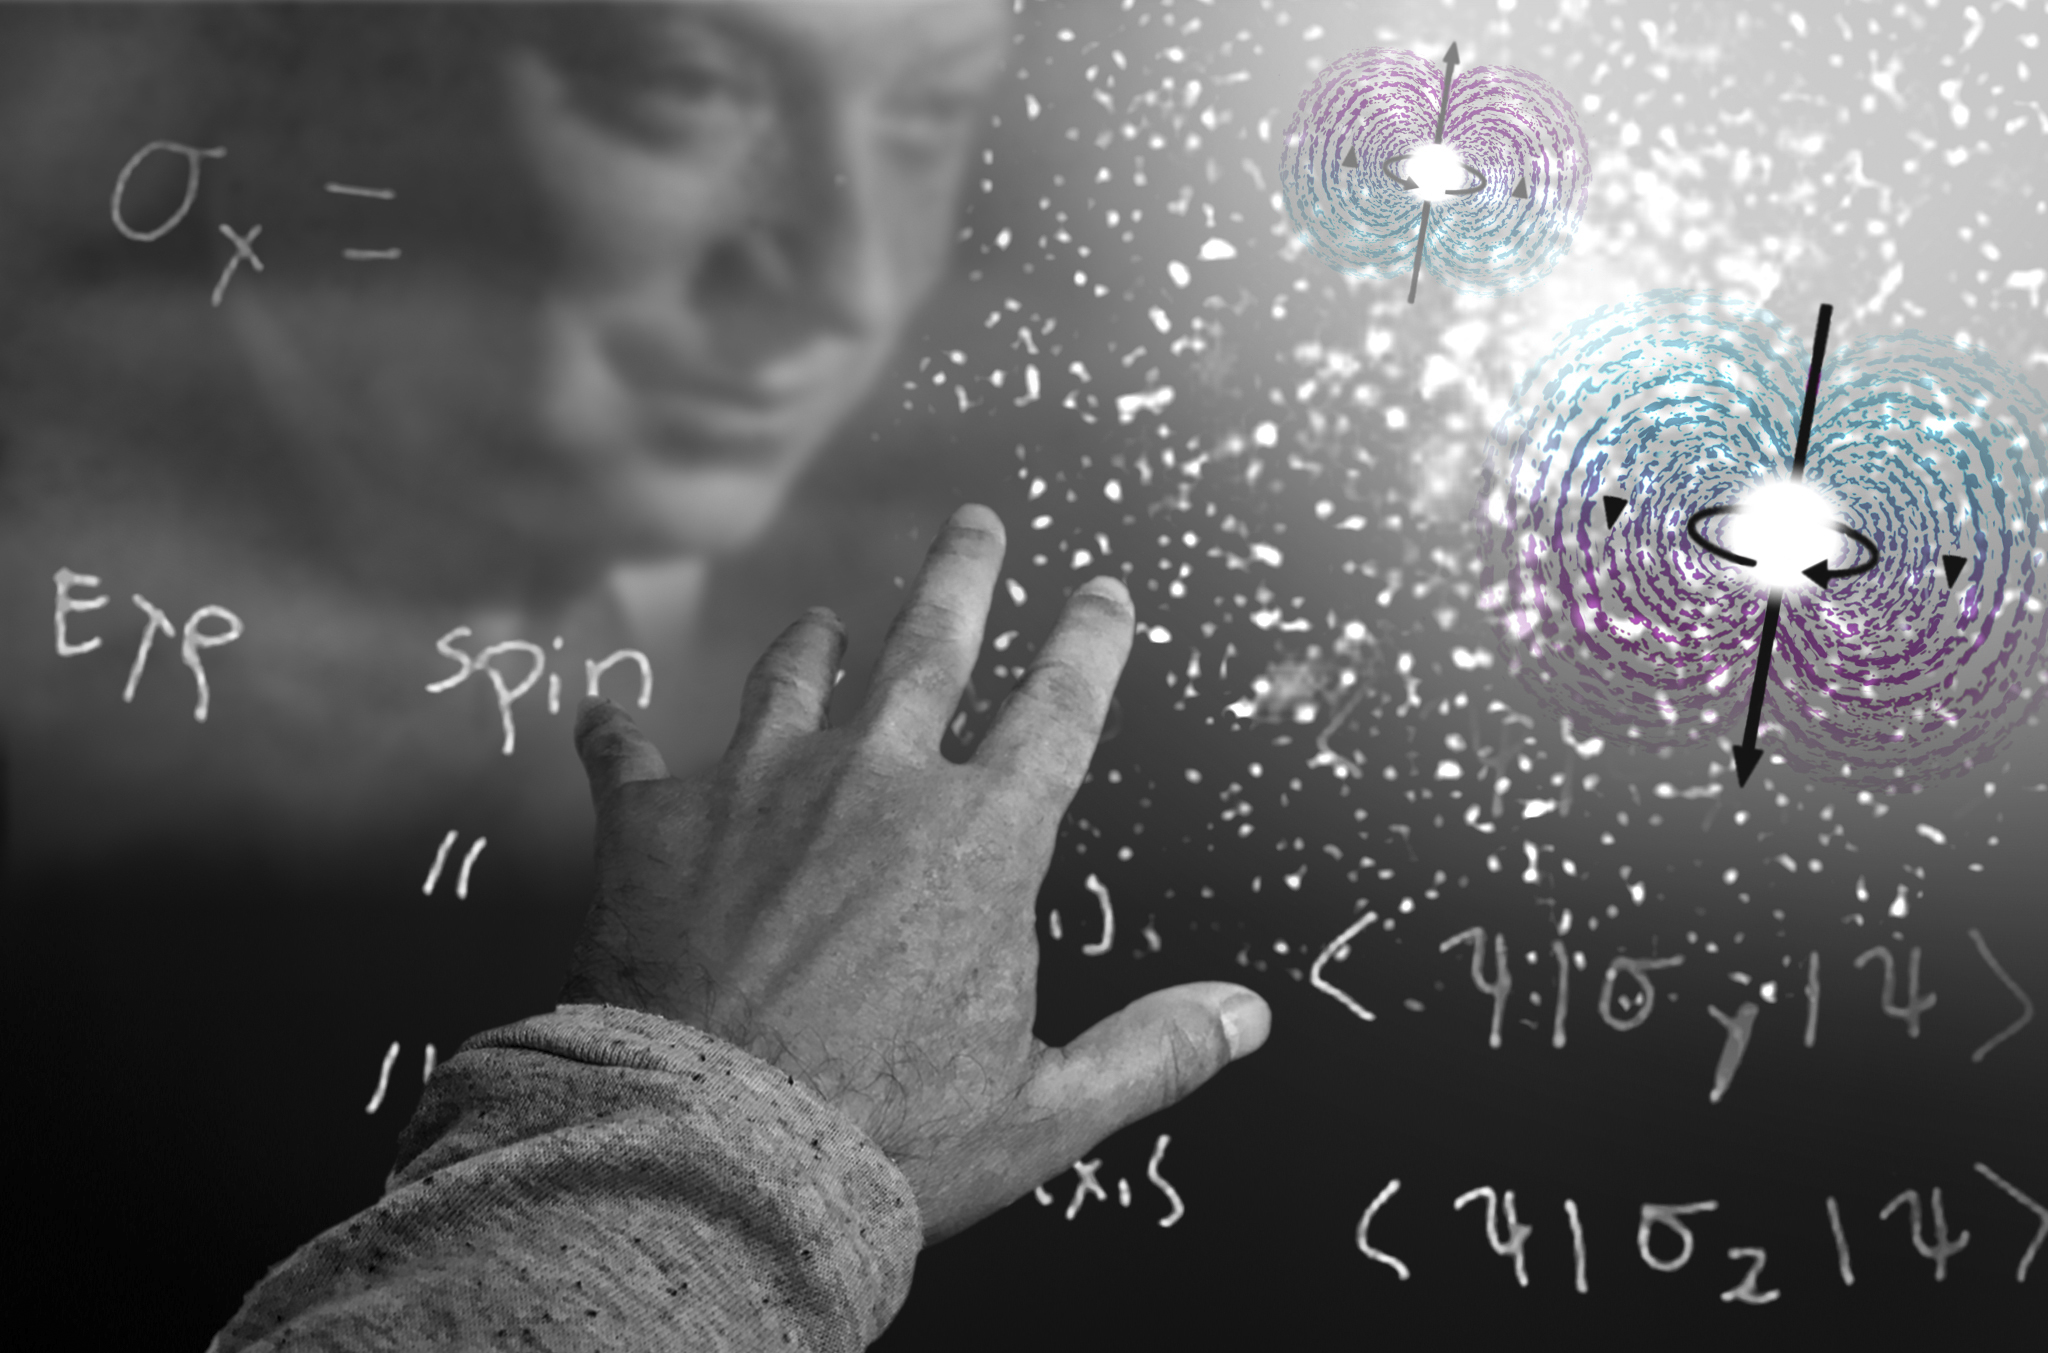

Figure 4.1 – Wolfgang Pauli reaching for a deeper understanding of the antisymmetry related to fermionic spin [authors]

# 4. Molecular Hamiltonians

At the end of Wolfgang Pauli’s 1946 Nobel lecture [Pauli] he states:

“I may express my critical opinion, that a correct theory should neither lead to infinite zero-point energies nor to infinite zero charges, that it should not use mathematical tricks to subtract infinities or singularities, nor should it invent a hypothetical world which is only a mathematical fiction before it is able to formulate the correct interpretation of the actual world of physics.”

The concepts in this chapter have a mathematical formulation and do not have a physical or chemical reality. In other words, there are standard approximations used that allow the determination of useful chemical quantities. The calculations that use the approximations do not represent exact quantities; rather, approximate quantities. Therefore, these approximations require a deeper understanding in order to obtain refinement and better answers. 

Furthermore, the approximations used in this chapter apply only to fermionic (electronic) systems. The extension to bosonic systems is an area of research by the broader scientific community. We will see the implementation and use of virtual orbitals and both occupied and unoccupied orbitals in calculations of ground state energy.

We mention different levels of implementation of the Hartree-Fock (HF) theory: Restricted Hartree-Fock (RHF), Restricted Open-shell Hartree-Fock (ROHF), and Unrestricted Hartree-Fock (UHF); however, through Qiskit, we will only show RHF. There are post-HF methodologies that one can use, such as Coupled-Cluster (CC), which we will be using in Chapter 5, Variational Quantum Eigensolver.

In this chapter, we solve the fermionic Hamiltonian equation for a hydrogen molecule and a lithium hydride molecule and will cover the following topics:
*   Section 4.1, Born-Oppenheimer approximation
*   Section 4.2, Fock space
*   Section 4.3, Fermionic creation and annihilation operators
*   Section 4.4, Molecular Hamiltonian in the Hartree-Fock orbitals basis
*   Section 4.5, Basis sets
*   Section 4.6, Constructing a fermionic Hamiltonian with Qiskit Nature
*   Section 4.7, Fermion to qubit mappings
*   Section 4.8, Constructing a qubit Hamiltonian operator with Qiskit Nature

# Technical requirements
A companion Jupyter notebook for this chapter can be downloaded from GitHub at https://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious, which has been tested in the Google Colab environment, which is free and runs entirely in the cloud, and in the IBM Quantum Lab environment. Please refer to Appendix B – Leveraging Jupyter Notebooks in the Cloud, for more information. The companion Jupyter notebook automatically installs the following list of libraries:
*   Numerical Python (NumPy) [NumPy], an open-source Python library that is used in almost every field of science and engineering
*   Qiskit [Qiskit], an open-source SDK for working with quantum computers at the level of pulses, circuits, and application modules
*   Qiskit visualization support to enable the use of visualizations and Jupyter notebooks
*   Qiskit Nature [Qiskit_Nature] [Qiskit_Nat_0], a unique platform that bridges the gap between natural sciences and quantum simulations
*   Python-based Simulations of Chemistry Framework (PySCF), [PySCF], an open-source collection of electronic structure modules powered by Python

# Summary of updates V2.1

Please refer to the following documentation:
*   The QubitConverter Migration Guide, https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
*   Transition from the PauliSumOp class and its widespread use to the qiskit.quantum_info module and its SparsePauliOp class, https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop

## Updates in import statements
### Transition from the PauliSumOp class and its widespread use to the qiskit.quantum_info module and its SparsePauliOp class
New statement
```
from qiskit_nature import settings
```

## Updates in code
### Transition from the PauliSumOp class and its widespread use to the qiskit.quantum_info module and its SparsePauliOp class
New statement
```
settings.use_pauli_sum_op = False
```
### Matrix representation of the fermionic Hamiltonian operator deprecated
The to_matrix method is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . This method has no direct replacement. Instead, use the `qiskit_nature.second_q.mappers.JordanWignerMapper` to create a qubit operator and subsequently use its `to_matrix()` method. Be advised, that the basis state ordering of that output will differ due to the bitstring endianness. For more information refer to https://github.com/Qiskit/qiskit-nature/issues/875.

### QubitConverter Migration
Previously
```
def label_to_qubit(label, converter):
    qubit_converter = QubitConverter(converter)
    f_op = FermionicOp(label)
    qubit_op = qubit_converter.convert(f_op)
    return qubit_op
```
New
```
# QubitConverter Migration
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
def label_to_qubit(label, mapper):
    f_op = FermionicOp(label)
    qubit_op = mapper.map(f_op)
    return qubit_op
```

Previously
```
def fermion_to_qubit(problem, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      # QubitConverter.convert
      # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.convert.html
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op, num_particles=problem.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op)
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter
```

New
```
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))

  match mapper_name:
    case "Jordan-Wigner":
      mapper = JordanWignerMapper()
    case "Parity":
      mapper = ParityMapper(num_particles=problem.num_particles)
    case "Bravyi-Kitaev":
      mapper = BravyiKitaevMapper()
  
  qubit_op = mapper.map(second_q_op)
  
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
    
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper
```

# Summary of updates V2
## Purpose
This Jupyter notebook has been adapted to work with Qiskit Nature v0.5 and the new Qiskit Runtime primitives. 

Please refer to the following documentation:

Electronic Structure Problems with v0.5, https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html

Leveraging Qiskit Runtime
https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html

FermionicOp
https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.operators.FermionicOp.html

## New install command
Install qiskit.utils with the following command (V2):
```
pip install qiskit.utils
```
## Updates in import statements
Previously
```
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.operators.second_quantization import FermionicOp
```
New
```
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.second_q.operators import FermionicOp
```

## Updates in code

### Removed figure 4.10 and figure 4.11 showing the molecular orbital (MO) 1-body and (MO) 2-body terms
The One body and two bodies integrals which were components of qiskit_nature.properties are no longer supported, see: https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html#qiskit_nature.properties

```
second_quantization.electronic.integrals.OneBodyElectronicIntegrals removed
second_quantization.electronic.integrals.TwoBodyElectronicIntegrals removed
```

### Updates pertaining to the new MoleculeInfo data structure
The MoleculeInfo has become a pure data container and no longer supports degrees of freedom.
This version uses a new dictionary to set up the MoleculeInfo data structure.

Previously
```
H2_molecule = Molecule(geometry=[['H', [0., 0., 0.]],['H', [0., 0., 0.735]]],charge=0, multiplicity=1)
```
New
```
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair=(1, 0)
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity, 'atom_pair':H2_atom_pair}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)
```

Previously
```
LiH_molecule = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., 1.5474]]], charge=0, multiplicity=1)
```

New
```
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)
```

### Updates pertaining to the get_particle_number() function
Previously
```
def get_particle_number(problem, show=True):
  particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
  num_particles = (particle_number.num_alpha, particle_number.num_beta)
  num_spin_orbitals = particle_number.num_spin_orbitals
  if show:
    print("Number of alpha electrons: {}".format(particle_number.num_alpha))
    print("Number of beta electrons: {}".format(particle_number.num_beta))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
  return particle_number
```
New
```
def get_particle_number(problem, qubit_converter, show=True):
  num_particles = qubit_converter.num_particles
  
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals
```
### Updates pertaining to the fermion_to_qubit() function
Now second_q_op is used as a replacement for second_q_op[0]

Previously
```
def fermion_to_qubit(f_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op[0], num_particles=f_op.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op[0])
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter
```
New
```
def fermion_to_qubit(problem, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      # QubitConverter.convert
      # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.convert.html
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op, num_particles=problem.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op)
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter
```
### Updates pertaining to the label_to_qubit() function
A FermionicOp is initialized with a dictionary, mapping terms to their respective coefficients.

```
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, BravyiKitaevMapper())
  print("{}:\n {}\n".format(k, qubit_op))
```
```
{'+_0': 1.0}:
 0.5 * X
+ -0.5j * Y

{'+_1': 1.0}:
 0.5 * XZ
+ -0.5j * YZ

{'+_2': 1.0}:
 0.5 * XZZ
+ -0.5j * YZZ

{'+_3': 1.0}:
 0.5 * XZZZ
+ -0.5j * YZZZ

{'+_4': 1.0}:
 0.5 * XZZZZ
+ -0.5j * YZZZZ
```

## Installing NumPy, Qiskit and importing various modules
Install NumPy with the following command:

In [ ]:
pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install Qiskit with the following command:

In [ ]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.6 MB/s eta 0:00:00


Install Qiskit visualization support with the following command:

In [ ]:
pip install 'qiskit[visualization]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136820 sha256=37c99c41adf2fb346d75396607bb369a8c36534a0ba8a39635b9fbf00e542459
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


Install qiskit.utils with the following command (V2):

In [ ]:
pip install qiskit.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for qiskit.utils: filename=qiskit_utils-1.2.1-py3-none-any.whl size=6546 sha256=b945bf25fa1ef0fb8c225eb4b61b32c69e7d384d3d7db0f12466f5ec9d877f1b
  Stored in directory: /root/.cache/pip/wheels/53/4a/ad/77d3cd72c62e79da4e674b809e43b0e576d630e53f3870f4d9
Successfully built qiskit.utils


Install Qiskit Nature with the following command:

In [ ]:
pip install qiskit-nature

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.8 MB/s eta 0:00:00


Install PySCF with the following command:

In [ ]:
pip install pyscf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.0 MB/s eta 0:00:00


Import NumPy with the following command:

In [ ]:
import numpy as np

Import Matplotlib, a comprehensive library for creating static, animated, and interactive visualizations in Python with the following command:



In [ ]:
import matplotlib.pyplot as plt

Import the required functions and class methods with the following commands. The array_to_latex function() returns a Latex representation of a complex array with dimension 1 or 2:

In [ ]:
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.quantum_info import SparsePauliOp
from qiskit.extensions import Initialize
#from qiskit.providers.aer import extensions  # import aer snapshot instructions

Import Qiskit Nature libraries with the following commands:

In [ ]:
from qiskit import Aer
#from qiskit_nature.drivers import UnitsType, Molecule

#from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
#from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
#from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
#from qiskit_nature.converters.second_quantization import QubitConverter

# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.second_q.operators import FermionicOp
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
from qiskit_nature import settings

#from qiskit_nature.operators.second_quantization import FermionicOp
#from qiskit_nature.circuit.library.initial_states import HartreeFock
#from qiskit_nature.circuit.library.ansatzes import UCCSD

Import the Qiskit Nature property framework with the following command:

In [ ]:
#from qiskit_nature.properties import Property, GroupedProperty
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.operators import ElectronicIntegrals

Import math libraries with the following command:

In [ ]:
import cmath
import math

# 4.1. Born-Oppenheimer approximation
Recall that the atomic orbital of an electron and the molecular orbital of an electron in a molecule are time independent stationary states. In section 2.4. Postulate 4 – Time independent stationary states we introduced the time-independent Schrödinger equation:

$$\hat{H}\left|\psi\right\rangle = E \left|\psi\right\rangle$$

where $\hat{H}$ is non-relative the Hamiltonian operator obtained by quantizing the classical energy in Hamilton form (first quantization) and it represents the total energy $(E)$ of all its particles; $N$ electrons and $M$ nuclei. For a molecular system, the electric charge of two nuclei $A$ and $B$ are $Z_A$ and $Z_B$ with masses $M_A$ and $M_B$. The position of the particles in the molecule is determined by using a laboratory (LAB) frame coordinate system as shown in Figure 4.2 where the origin of the coordinate system is outside the molecule. The origin of the coordinate system can be placed anywhere in free space.



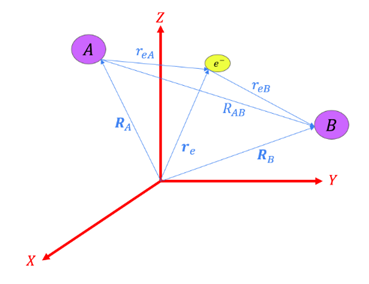

Figure 4.2 – LAB Frame Coordinates

The Hamiltonian in the LAB frame coordinates $\hat{H}_{LAB}$ is:

$$\hat{H}_{LAB}=-\frac{1}{2} \sum_{p=1}^{N} \nabla_{r_{p}}^{2}-\sum_{A=1}^{M} \frac{1}{2 M_{A}} \nabla_{R_{A}}^{2}-\sum_{p=1}^{N} \sum_{A=1}^{M} \frac{\mathrm{Z}_{A}}{r_{p A}}+\sum_{q>p=1}^{N} \frac{1}{r_{p q}}+\sum_{B>A=1}^{M} \frac{\mathrm{Z}_{A} \mathrm{Z}_{B}}{R_{A B}}$$

comprising the sum of the kinetic energy of all particles and the potential energy between all particles with the following definitions:

- $\nabla_{r_{p}}^{2}$ and $\nabla_{R_{A}}^{2}$ are the second derivative operator with respect to the position coordinates for electrons and nuclei, i.e.$\nabla_{R_{A}}^{2}=\frac{\partial^{2}}{\partial_{x_{A}}^{2}}+\frac{\partial^{2}}{\partial_{y_{A}}^{2}}+\frac{\partial^{2}}{\partial_{z_{A}}^{2}}$,

- $r_{p q}=\left|\boldsymbol{r}_{p}-\boldsymbol{r}_{q}\right|$, $r_{p A}=\left|\boldsymbol{r}_p-\boldsymbol{r}_A\right|$, and $R_{A B}=\left|\boldsymbol{R}_A-\boldsymbol{R}_B\right|$ are the distance between electrons $p$ and $q$, electron $p$ and nucleus $A$, and nuclei $A$ and $B$ determined by the Euclidean norm.

For clarity, we list the operators of the LAB Hamiltonian in Figure 4.3:

$$\begin{array}{|c|c|}
\hline
\text{Operator}&\text{Description}\\
\hline
-\frac{1}{2} \sum_{p=1}^{N} \nabla_{{r}_{p}}^{2}&\text{Electronic kinetic energy operator.}\\
\hline
-\sum_{A=1}^{M} \frac{1}{2 M_{A}} \nabla_{R_{A}}^{2}&\text{Nuclear kinetic energy operator.}\\
\hline
-\sum_{p=1}^{N} \sum_{A=1}^{M} \frac{\mathrm{Z}_{A}}{r_{p A}}&\text{Potential energy between the electrons and nuclei.}\\
\hline
 \sum_{q>p=1}^{n} \frac{1}{r_{p q}}&\text{Potential energy operator arising from electron-electron Coulombic repulsions.}\\
\hline
 \sum_{B>A=1}^{M} \frac{\mathrm{Z}_{A} \mathrm{Z}_{B}}{R_{A B}}&\text{Potential nuclear repulsion energy operator.}\\
\hline
\end{array}$$

Figure 4.3 – Terms of the Hamiltonian operator for a molecule

In the LAB Hamiltonian, the energy of the molecular system is continuous, not discrete. The center-of-mass (COM) motion does not yield any change to the energy of the internal states of the system and can be factored out. The internal states are quantized and invariant to translations. These states are not affected by translational and rotational motions in free space. The nuclei can still move around the COM through vibrations and internal rotations.

In the BO approximation, we assume that the motions of the nuclei are uncoupled from the motions of the electrons, i.e. a product of nuclear equations (rotational and vibrational) end electronic equations:

$$\left|\Psi_{\text {total }}\right\rangle=\Psi_{\text {rot}}(\boldsymbol{R}) \Psi_{\text {vib}}(\boldsymbol{R}) \Psi_{\text {elec}}(\boldsymbol{r}: \boldsymbol{R})$$

where the electronic wave function $\Psi_{\text {elec}}(\boldsymbol{r}: \boldsymbol{R})$ is condition on the nuclear coordinates $(R)$. In this approximation, solving for only the electronic equation, the nuclei of the atoms are fixed in space and not moving, which can be thought as a violation of the Heisenberg uncertainty principle introduced in section 1.4. Light and Energy. We are only dealing with electrons moving around stationary nuclei. Hence, if we ignore the kinetic energy coupling terms of the nuclei and the nuclei with electrons, the general electronic Hamiltonian is a sum of four operators as shown:

$$\hat{H}_{elec}=-\frac{1}{2} \sum_{p=1}^{N} \nabla_{r_{p}}^{2}-\sum_{p=1}^{N} \sum_{A=1}^{M} \frac{\mathrm{Z}_{A}}{r_{p A}}+\sum_{q>p=1}^{N} \frac{1}{r_{p q}}+\sum_{B>A=1}^{M} \frac{\mathrm{Z}_{A} \mathrm{Z}_{B}}{R_{A B}}$$

The last term, the potential nuclear repulsion energy, is not computed and is approximated with pseudopotentials and experimental data, and we will show this in Figure 4.4. This approximation has limitations that we cover further in Chapter 6, Beyond Born-Oppenheimer, specifically through determining potential energy surfaces.

# 4.2. Fock space
The electronic wave function  $\Psi_{\text {elec}}(\boldsymbol{r}: \boldsymbol{R})$ includes the spatial position for each electron ($\boldsymbol{r}_{i}=\left\{x_{i}, y_{i}, z_{i}\right\}$) conditioned on the nuclei and the spin directional coordinates for each electron ($\boldsymbol{s}_{i}=\left\{s_{x_{i}}, s_{y_{i}}, s_{z_{i}}\right\}$). The electronic wave function must be antisymmetric with respect to the exchange of pair particle labels because these particles are fermions. Please recall that this is the Pauli exclusion principle introduced in section 2.1.3. General formulation of the Pauli exclusion principle. 

Now, let us consider two electrons in states $\left|\boldsymbol{r}_{i}, \boldsymbol{s}_{i}\right\rangle$ and $\left|\boldsymbol{r}_{j}, \boldsymbol{s}_{j}\right\rangle$. The total wave function of two electrons is anti-symmetric $(-)$ with respect to the exchange of identical pair particles $(A_{ij})$:

$$\Psi_{\text {elec }}\left(\boldsymbol{r}_{i}, \boldsymbol{r}_{j}\right)=\frac{1}{\sqrt{2}}\left(\left|\boldsymbol{r}_{i}, \boldsymbol{s}_{i}\right\rangle \otimes\left|\boldsymbol{r}_{j}, \boldsymbol{s}_{j}\right\rangle-\left|\boldsymbol{r}_{j}, \boldsymbol{s}_{j}\right\rangle \otimes\left|\boldsymbol{r}_{i}, \boldsymbol{s}_{i}\right\rangle\right)$$

Since one-body electronic wavefunction is a product of spatial $\left(\psi\left(\boldsymbol{r}_{1}\right)\right)$ and spin components $\left(\chi\left(s_{1}\right)\right)$, there are two scenarios where antisymmetry can be achieved:

1.	the spin function must be antisymmetric while the spatial is symmetric
2.	the spatial function must be antisymmetric while the spin function is symmetric 

This means that when two particles are swapped, the total molecular wave function describing the system also changes sign: 

$$\hat{A}_{i j}\left|\Psi_{\text {total }}\right\rangle=-\left|\Psi_{\text {total }}\right\rangle$$

For $N$ electrons in the field of nuclei, the total wave function $\left|\Psi_{\text {total }}\left(\boldsymbol{r}_{1}, \ldots, \boldsymbol{r}_{N}, \boldsymbol{s}_{1}, \ldots, \boldsymbol{s}_{N}\right)\right\rangle$ can be written as a product of atomic one-body spin orbitals:

$$
\Psi_{\text {elec }}(\boldsymbol{r}, \boldsymbol{s} ; \boldsymbol{R})=\Psi_{1}(\boldsymbol{r}, \boldsymbol{s} ; \boldsymbol{R}) \wedge \Psi_{2}(\boldsymbol{r}, \boldsymbol{s} ; \boldsymbol{R}) \wedge \ldots \wedge \Psi_{N}(\boldsymbol{r}, \boldsymbol{s} ; \boldsymbol{R})
$$

and is made to be anti-symmetric through an antisymmetric tensor product $\wedge$ [Toulouse] and through superposition of states using the Slater determinant first introduced by Dirac [Kaplan]:

$$
\Psi_{\text {elec }}(\boldsymbol{r}, \boldsymbol{s} ; \boldsymbol{R})
=\frac{1}{\sqrt{N !}}\left|\begin{array}{cccc}
\left|\Psi_{1}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1}\right)\right\rangle & \left|\Psi_{1}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2}\right)\right\rangle & \ldots & \left|\Psi_{1}\left(\boldsymbol{r}_{N}, \boldsymbol{s}_{N}\right)\right\rangle \\
\left|\Psi_{2}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1}\right)\right\rangle & \left|\Psi_{2}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2}\right)\right\rangle & \ldots & \left|\Psi_{2}\left(\boldsymbol{r}_{N}, \boldsymbol{s}_{N}\right)\right\rangle \\
\ldots & \ldots & \ldots & \ldots \\
\left|\Psi_{N}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1}\right)\right\rangle & \left|\Psi_{N}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2}\right)\right\rangle & \ldots & \left|\Psi_{N}\left(\boldsymbol{r}_{N}, \boldsymbol{s}_{N}\right)\right\rangle
\end{array}\right|$$

The Slater determinant wave function is antisymmetric with respect to the exchange of two electrons (permutation of two rows) or with respect to the exchange of two spin orbitals (permutation of two columns). 

For two electrons ($N=2$), the Slater determinant has the form:

$$
\Psi_{\text {elec }}\left(\boldsymbol{r}_{1}, \boldsymbol{r}_{2} ; \boldsymbol{R}\right)=\frac{1}{\sqrt{2}}\left|\begin{array}{ll}
\Psi_{1}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) & \Psi_{1}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right) \\
\Psi_{2}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) & \Psi_{2}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right)
\end{array}\right|
$$

$$
=\frac{1}{\sqrt{2}}\left(\Psi_{1}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) \otimes \Psi_{2}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right)-\Psi_{1}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right) \otimes \Psi_{2}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right)\right)
$$

For three electrons ($N=3$),  the Slater determinant has the form:

$$
\Psi_{\text {elec }}\left(\boldsymbol{r}_{1}, \boldsymbol{r}_{2}, \boldsymbol{r}_{3}, \boldsymbol{s}_{1}, \boldsymbol{s}_{2}, \boldsymbol{s}_{3} ; \boldsymbol{R}\right)=\frac{1}{\sqrt{6}}\left|\begin{array}{lll}
\Psi_{1}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) & \Psi_{1}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right) & \Psi_{1}\left(\boldsymbol{r}_{3}, \boldsymbol{s}_{3} ; \boldsymbol{R}\right) \\
\Psi_{2}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) & \Psi_{2}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right) & \Psi_{2}\left(\boldsymbol{r}_{3}, \boldsymbol{s}_{3} ; \boldsymbol{R}\right) \\
\Psi_{3}\left(\boldsymbol{r}_{1}, \boldsymbol{s}_{1} ; \boldsymbol{R}\right) & \Psi_{3}\left(\boldsymbol{r}_{2}, \boldsymbol{s}_{2} ; \boldsymbol{R}\right) & \Psi_{3}\left(\boldsymbol{r}_{3}, \boldsymbol{s}_{3} ; \boldsymbol{R}\right)
\end{array}\right|
$$

$$
\begin{aligned}
=& \frac{1}{\sqrt{6}}\left\{\Psi_{1}\left(r_{1}, s_{1} ; R\right) \otimes\left(\Psi_{2}\left(r_{2}, s_{2} ; R\right) \otimes \Psi_{3}\left(r_{3}, s_{3} ; R\right)-\Psi_{2}\left(r_{3}, s_{3} ; R\right) \otimes \Psi_{3}\left(r_{2}, s_{2} ; R\right)\right)\right.\\
&-\Psi_{1}\left(r_{2}, s_{2} ; R\right) \otimes\left(\Psi_{2}\left(r_{1}, s_{1} ; R\right) \otimes \Psi_{3}\left(r_{3}, s_{3} ; R\right)-\Psi_{2}\left(r_{3}, s_{3} ; R\right) \otimes \Psi_{3}\left(r_{1}, s_{1} ; R\right)\right) \\
&\left.+\Psi_{1}\left(r_{3}, s_{3} ; R\right) \otimes\left(\Psi_{2}\left(r_{1}, s_{1} ; R\right) \otimes \Psi_{3}\left(r_{2}, s_{2} ; R\right)-\Psi_{2}\left(r_{2}, s_{2} ; R\right) \otimes \Psi_{3}\left(r_{1}, s_{1} ; R\right)\right)\right\}
\end{aligned}
$$

The Fock space [Fock] is the Hilbert space in which the Slater determinant wave functions belong. By definition, a Fock space is the sum of a set of Hilbert spaces representing at least three important configurations:

1. the zero-particle state also called the vacuum state is interpreted as the absence of an electron in an orbital: $|vac\rangle$ or $|0\rangle$,  
2. one particle states: $\left|\boldsymbol{r}_{\mathrm{p}}, \boldsymbol{s}_{\mathrm{p}}\right\rangle$ or $|1\rangle$
3. two particle states $\left|\boldsymbol{r}_{\mathrm{i}}, \boldsymbol{s}_{\mathrm{i}}, \boldsymbol{r}_{\mathrm{j}}, \boldsymbol{s}_{\mathrm{j}}\right\rangle=\frac{1}{\sqrt{2}}\left(\left|\boldsymbol{r}_{j}, \boldsymbol{s}_{j}\right\rangle \otimes\left|\boldsymbol{r}_{i}, \boldsymbol{s}_{i}\right\rangle-v\left|\boldsymbol{r}_{i}, \boldsymbol{s}_{i}\right\rangle \otimes\left|\boldsymbol{r}_{j}, \boldsymbol{s}_{j}\right\rangle\right)$ or $|11\rangle$

The number of states of an $n$-particle subspace of the Fock space of $N$ electrons is:

$$\left(\begin{array}{l} N \\ n \end{array}\right)=\frac{N !}{n !(N-n)}$$

where $\left(\begin{array}{l} N \\ n \end{array}\right)$ denotes the number of n-combinations from a set of N elements.

If we have 5 electrons with 3-particle subspace: 

$$\left(\begin{array}{l}
5 \\
3
\end{array}\right)=\frac{5 !}{3 !(5-3)}=\frac{5 \times 4 \times 3 \times 2 \times 1}{3 \times 2 \times 1 \times 2}=10$$

The total number of states in a Fock space of $N$ electrons is [Wiki-Comb]:

$$\sum_{n=0}^{N}\left(\begin{array}{l} N \\ n \end{array}\right)=\sum_{n=0}^{N} \frac{N !}{n !(N-n)}=2^{N}$$

What we present here in this section is only a mathematical construction and does not represent a physical reality nor chemical actuality. Therefore, in some ways, it is difficult to relate to the ideas and terms we use to actual chemistry taking place. However, the Fock space is exploited in quantum computing because there a one-to-one mapping between the electron space of a molecule and the qubit space; but it not a necessary mapping. There are other mappings that are more computationally advantageous such as the one presented in Section 4.7.4, Bravyi-Kitaev transformation.

# 4.3. Fermionic creation and annihilation operators
What we present here in this section is only a mathematical construction and does not represent a physical reality nor chemical actuality. Therefore, in some ways, it is difficult to relate to the ideas and terms we use. 
Each electron can occupy only one spin-orbit at a time and no two electrons can occupy the same spin-orbit.

Now we further consider a subspace of the Fock space, which is spanned by the occupation number of the spin-orbits which is described by $2^N$ electronic basis states $\left|f_{0} \ldots f_{\mathrm{N}-1}\right\rangle$, where $f_j∈\{0,1\}$ is the occupation number of orbital $j$. 

The spin orbital state $j$ not occupied by an electron is represented by $\left|f_{0} \ldots 0_{j} \ldots f_{N-1}\right\rangle$. 

We define a set of fermionic annihilation operators $\{a_i\}_{i=0}^{N-1}$ and creation operators $\{a_j^†\}_{j=0}^{N-1}$ which act on local fermion modes, and which satisfy the following anti-commutation relations:

$$\{a ̂_i,a ̂_j^†\}=a_i^† a_j+a_j a_i^†=\delta_{i j}=\left\{\begin{array}{ll}
0, & i \neq j \\
1, & i=j
\end{array}\right\}$$

$$\{a_i^†,a_j^†\}=\{a ̂_i,a ̂_j\}=0$$

where: $\delta_{i j}$ is the Dirac delta function. The operators $\{a_j^†a_j\}_{j=0}^{N-1}$ are called the occupation number operators. They commute with each other.

A fermionic operator is a linear combination of products of creation and annihilation operators, which we discuss next.

## 4.3.1. Fermion creation operator
The fermion creation operator $\hat{a}_i^\dagger$ raises by one unit the number of particles sitting in the $i^{th}$ fermionic orbital:

$$\hat{a}_i^†|\ldots m_i \ldots\rangle=(1-m_i)(-1)^{\sum_{j<i} m_{j}} |\ldots (m+1)_i \ldots\rangle$$

where:
- $m_i$ and $(m+1)_i$ are the number of particles sitting in the $i^{th}$ fermionic orbital.
- $(1-m_i)$ is a pre-factor which annihilates the state if we had an electron in the $i^{th}$ fermionic orbital, i.e. if $m_i=1$.
- The phase factor $(-1)^{\sum_{j<i} m_{j}}$  keeps the anti-symmetric properties of the whole superposition of states.

## 4.3.2. Fermion annihilation operator
The fermion annihilation operator $a_i$ lowers by one unit the number of particles sitting in the $i^{th}$ fermionic orbital:

$$\hat{a}_i|\ldots m_i \ldots\rangle=m_i(-1)^{\sum_{j<i} m_{j}} |\ldots (m-1)_i \ldots\rangle$$

where:
- $m_i$ and $(m-1)_i$ are the number of particles sitting in the $i^{th}$ fermionic orbital.
- $m_i$ is a pre-factor which annihilates the state in the Slater determinant if there is no electron in the $i^{th}$ fermionic orbital, i.e. if $m_i=0$ .
- The phase factor $(-1)^{\sum_{j<i} m_{j}}$ keeps the anti-symmetric properties of the whole superposition of states.


# 4.4. Molecular Hamiltonian in the Hartree-Fock orbitals basis
For mapping the original electronic structure Hamiltonian into the corresponding qubit Hamiltonian, we work in the second quantization formalism of quantum mechanics. The Hartree-Fock (HF) method approximates a N-body problem into N one-body problems where each electron evolves in the mean-field of the others. 

We can rewrite the electronic molecular Hamiltonian $(\hat H_{elec})$ as a linear combination of products of creation and annihilation operators (summarized in Figure 4.4):

$$
\hat{H}_{elec} =\sum_{i, j} h_{i j} \hat{a}_{i}^{\dagger} \hat{a}_{j} +\frac{1}{2} \sum_{i, j, k, l} g_{i j k l} \hat{a}_{i}^{\dagger} \hat{a}_{j}^{\dagger} \hat{a}_{l} \hat{a}_{k}+E_{N N}
$$

where $a _j$ removes an electron from spin-orbital $j$, and $a _i^†$ creates an electron in spin-orbital $i$. The operation $â_i^†$ $a ̂_j$ is the excitation operator which excites an electron from the occupied spin-orbital $
\psi_{j}\left(\boldsymbol{r}_{p}\right) \chi_{j}\left(\boldsymbol{s}_{p}\right)
$ into the unoccupied orbital $\psi_{i}\left(\boldsymbol{r}_{p}\right) \chi_{i}\left(\boldsymbol{s}_{p}\right)$. Constructing these were introduced in Section 2.1, Postulate 1 – Wave functions. The nuclear-nuclear (NN) repulsion energy (E_NN) approximated by pseudopotentials and experimental data as mentioned in Section 4.1, Born-Oppenheimer approximation.

$$\begin{array}{|c|c|c|}
\hline
\text{Molecular Hamiltonian in the BO approximation}& \text{Linear combination of creation annihilation operators} &\text{Description}\\
\hline
-\frac{1}{2} \sum_{p=1}^{N} \nabla_{p}^{2}& -\frac{1}{2} \sum_{i, j}\left\langle i\left|\nabla_{i}^{2}\right| j\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j} & \text{Electronic kinetic energy operator.}\\
\hline
-\sum_{p=1}^{N} \sum_{A=1}^{M} \frac{\mathrm{Z}_{A}}{r_{p A}}& \sum_{i, j}\left\langle i\left|\frac{\mathrm{Z}_{A}}{r_{i A}}\right| j\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j} & \text{Potential energy between the electrons and nuclei.}\\
\hline
+\sum_{q>p=1}^{n} \frac{1}{r_{p q}}& \sum_{i, j, k, l}\left\langle i, j\left|\frac{1}{r_{i j}}\right| k, l\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j}^{\dagger} \hat{a}_{l} \hat{a}_{k} & \text{Potential energy operator arising from electron-electron Coulomb repulsions.}\\
\hline
+\sum_{B>A=1}^{M} \frac{\mathrm{Z}_{A} \mathrm{Z}_{B}}{r_{A B}}& E_{NN} & \text{Potential nuclear-nuclear (} NN \text{) repulsion energy operator.}\\
\hline
\end{array}$$

Figure 4.4 – Molecular Hamiltonian as a linear combination of products of creation and annihilation operators

The weights of operators are given by the one electron integrals using the HF method:

$$h_{i, j}=\langle i|\hat{h}| j\rangle=\int d \boldsymbol{r}_{1} d \boldsymbol{s}_{1} \psi_{i}^{*}\left(\boldsymbol{r}_{1}\right) \chi_{i}^{*}\left(\boldsymbol{s}_{1}\right)\left(-\frac{1}{2} \nabla_{\boldsymbol{r}_{1}}^{2}-\sum_{I} \frac{Z_{I}}{\left|r_{1}-R_{I}\right|}\right) \psi_{j}\left(\boldsymbol{r}_{1}\right) \chi_{j}\left(\boldsymbol{s}_{1}\right)$$

where $r_{i}$ are the coordinates of electron $i$, $R_{i}$ are the coordinates of atom $I$ and $Z_{i}$ is the atomic number of atom $I$ and and the two-electron terms are given by:

$$g_{i, j, k, l}=\langle i, j|\hat{g}| k, l\rangle=\int d \boldsymbol{r}_{1} d \boldsymbol{r}_{2} d \boldsymbol{s}_{1} d \boldsymbol{s}_{2} \frac{\psi_{i}^{*}\left(\boldsymbol{r}_{1}\right) \chi_{i}^{*}\left(\boldsymbol{s}_{1}\right) \psi_{j}^{*}\left(\boldsymbol{r}_{2}\right) \chi_{j}^{*}\left(\boldsymbol{s}_{2}\right) \psi_{k}\left(\boldsymbol{r}_{1}\right) \chi_{k}\left(\boldsymbol{s}_{1}\right) \psi_{l}\left(\boldsymbol{r}_{2}\right) \chi_{l}\left(\boldsymbol{s}_{2}\right)}{\left|r_{1}-r_{2}\right|}$$

The molecular Hamiltonian can be expressed in the basis of the solutions of the HF method $\left\{\psi_{i}(\boldsymbol{r})\right\}$, also called Molecular Orbitals (MOs) [Panagiotis]:

$$\widehat{H}_{e l e c}=-\frac{1}{2} \sum_{i, j}\left\langle i\left|\nabla_{i}^{2}\right| j\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j}+\sum_{i, j}\left\langle i\left|\frac{\mathrm{Z}_{A}}{r_{i A}}\right| j\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j}+\sum_{i, j, k, l}\left\langle i, j\left|\frac{1}{r_{i j}}\right| k, l\right\rangle \hat{a}_{i}^{\dagger} \hat{a}_{j}^{\dagger} \hat{a}_{l} \hat{a}_{k}+E_{\mathrm{NN}}$$

We showed some example calculations of these integrals Section 2.3.6, Kinetic energy operation and Section 2.3.7, Potential energy operation. In the next section we will see how to approximate the spatial wave functions in those integrals.

There are three commonly used HF methods:
-	The restricted HF (RHF) method is used for closed- shell molecules. The spin-orbitals are either alpha (spin-up) or beta (spin-down) and all orbitals are doubly occupied by alpha and beta spin-orbitals.
-	The restricted open-shell (ROHF) method is used for open- shell molecules where the numbers of electrons of each spin are not equal. ROHF uses as many doubly occupied molecular orbitals as possible and singly occupied orbitals for the unpaired electrons.
-	The unrestricted HF (UHF) method is used for open- shell molecules where the numbers of electrons of each spin are not equal. UHF orbitals can have either alpha or beta spin, but the alpha and beta orbitals may have different spatial components.

# 4.5. Basis sets
The spatial wave functions, $ψ(r)$ in the integrals of Section 4.4, Molecular Hamiltonian in the Hartree-Fock orbitals basis are approximated by linear combinations of several independent basis functions. The form of these functions is inspired by the atomic orbitals of hydrogen-like systems that we introduced in section 2.1.1, Spherical harmonic functions which have a radial part as shown in section 2.2.1, Computing the radial wavefunctions. 

Two classes of approximate basis orbitals that are commonly used are Slater-type orbitals (STO’s) based on the Slater determinant introduced in Section 4.2, Fock Space, and Cartesian Gaussian-type orbitals (GTOs). These two types of basis functions can be combined as STO-nG where n is the number of Gaussian used to make the approximation. Ab Initio electronic structure computations are conducted numerically using a basis set of orbitals.

We now detail the structure of these two classes and illustrate them with Python plots of functions.

## 4.5.1. Slater-type orbitals
Slater-type orbitals (STOs) have the same structure as the atomic orbitals of hydrogen-like systems and their radial part have the following form:

$$R_l(r)=A(l,\alpha) r^l e^{-\alpha r}$$

where:

*   $l$ is the angular momentum quantum with values ranging from $0$ to $n-1$, where $n$ is the principal quantum number,
*   $r$ is the nuclear distance of the electron from the atomic nucleus,
*   $\alpha$  is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance.

$A(l,\alpha)$ is determined by the following normalization condition [Wiki-GAU]:

$$\int_{0}^{\infty}\left|R_{l}(r)\right|^{2} r^{2} d r=1$$

$$A(l, \alpha)^{2} \int_{0}^{\infty}\left(r^{l} e^{-\alpha r}\right)^{2} r^{2} d r=1$$

Noting that [Wiki-STO]:

$$\int_{0}^{\infty} x^{l} e^{-\alpha x} d x=\frac{l !}{\alpha^{n+1}}$$

we have:

$$A(l,\alpha)=(2 \alpha)^{n} \sqrt{\frac{2 \alpha}{(2 l) !}}$$

For the $1s$ orbital, we have $l=0$, hence $A(l,\alpha)=2\alpha^{\frac{3}{2}}$ and the radial part of the slater orbital is:

$$R(r)=2\alpha^{\frac{3}{2}} e^{-\alpha r}$$

Let us plot this function with the following Python code. Figure 4.5 shows the result:

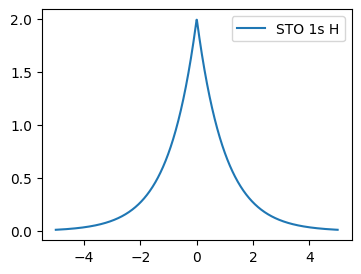

In [ ]:
x = np.linspace(-5,5,num=1000)
r = abs(x)

alpha = 1.0

R = 2*alpha**(1.5)*np.exp(-alpha*r)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="STO 1s H")
plt.legend()

Figure 4.5 – Plot of the radial part of the Slater-type orbital for the $1s$ orbital of the hydrogen atom

We plot the antisymmetric spatial wavefunction for the hydrogen molecule as a linear combination of the above radial part of the slater orbital for a hydrogen atom as follows. Figure 4.6 shows the result:

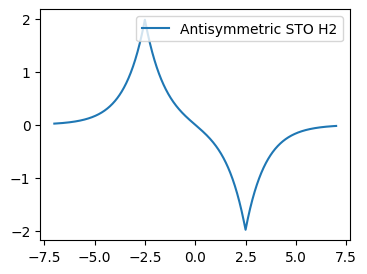

In [ ]:
x = np.linspace(-7,7,num=1000)
r1 = abs(x+2.5)
r2 = abs(x-2.5)

alpha = 1.0

R = 2*alpha**(1.5)*np.exp(-alpha*r1)-2*alpha**(1.5)*np.exp(-alpha*r2)

plt.figure(figsize=(4,3))
plt.plot(x,R,label="Antisymmetric STO H2")
plt.legend()

Figure 4.6 – Plot of the anti-symmetric wave function of the hydrogen molecule

## 4.5.2. Gaussian-type orbitals
Gaussian-type orbitals (GTOs) have the same angular form of STOs, but their radial function adopts a gaussian form:

$$R_l(r)=B(l,\alpha) r^l e^{-\alpha r^2}$$

where:

*   $l$ is the angular momentum quantum with values ranging from $0$ to $n-1$, where $n$ is the principal quantum number,
*   $r$ is the nuclear distance of the electron from the atomic nucleus,
*   $\alpha$  is called the orbital exponent and controls how fast the density of the orbital vanishes as a function of the nuclear distance.

$B(l,\alpha)$ is determined by the following normalization condition [Wiki-GAU]:

$$\int_{0}^{\infty}\left|R_{l}(r)\right|^{2} r^{2} d r=1$$

In practice, we approximate the radial part of a STO with a linear combination of primitive Gaussian functions, called a contracted Gaussian function (CG). The STO-nG basis sets include one contracted Gaussian function per atomic orbital [Skylaris]. We plot the STO-3G function for the $1s$ orbital of the hydrogen atom. Here is the code. Figure 4.7 shows the result:

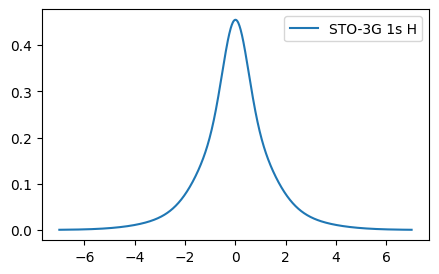

In [ ]:
x = np.linspace(-7,7,num=1000)
r = abs(x)

c = [0.444635,0.535328,0.154329]
alpha = [0.109818,0.405771,2.227660]

psi = 0
for k in range(3):
  psi += c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r**2)

plt.figure(figsize=(5,3))
plt.plot(x,psi,label="STO-3G 1s H")
plt.legend()

Figure 4.7 – Plot of the STO-3G function for the $1s$ orbital of the hydrogen atom

We plot the antisymmetric spatial wavefunction for the hydrogen molecule as a linear combination of the above radial part of the STO-3G function for the 1 s orbital for a hydrogen atom as follows. Figure 4.8 shows the result:

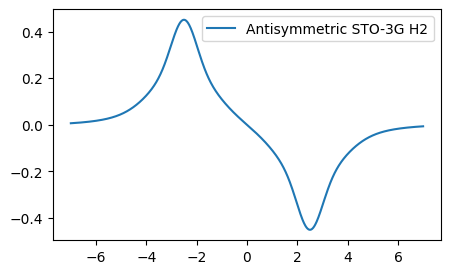

In [ ]:
x = np.linspace(-7,7,num=1000)
r1 = abs(x+2.5)
r2 = abs(x-2.5)

c = [0.444635,0.535328,0.154329]
alpha = [0.109818,0.405771,2.227660]

psi = 0
for k in range(3):
  psi += c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r1**2) \
  - c[k]*(2*alpha[k]/np.pi)**0.75 * np.exp(-alpha[k]*r2**2)

plt.figure(figsize=(5,3))
plt.plot(x,psi,label="Antisymmetric STO-3G H2")
plt.legend()

Figure 4.8 – Plot of the antisymmetric STO-3G function for the $1s$ orbital of the hydrogen molecule

# 4.6. Constructing a fermionic Hamiltonian with Qiskit Nature
The Qiskit Nature platform works with spin orbitals (SOs) [Qiskit_Nat_1]. Each molecular orbital can have a spin-up, or a spin-down electron, or spin-paired electrons. A spin orbital is either of those cases. For each molecular orbital we have two spin orbitals. Let us now illustrate the construction of a fermionic Hamiltonian operator of the hydrogen molecule with Qiskit Nature.

## 4.6.1. Constructing a fermionic Hamiltonian operator of the hydrogen molecule
The Qiskit Nature platform works with spin orbitals. Each molecular orbital can have a up spin and a down spin electron. A spin orbital is either of those cases. For each molecular orbital we have two spin orbitals. Let us now illustrate the construction of a fermionic Hamiltonian operator of the hydrogen molecule. First we define the molecular geometry of the Hydrogen molecule:

- geometry, a list of atom names, e.g. ‘H’ for hydrogen, followed by Cartesian coordinates $(x, y, z)$ of the atom’s position in units of angstroms.
- charge, integer, the electric charge on the molecule.
- multiplicity, integer, the multiplicity $2S+1$ of the molecule, where $S$ is the total spin angular momentum which is determined by the number of unpaired electrons in the molecule, that is the number of electrons that occupy a molecular orbital singly, not with another electron.

In [ ]:
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair=(1, 0)
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity, 'atom_pair':H2_atom_pair}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

We define the electronic structure molecule driver by selecting the Python-based Simulations of Chemistry Framework (PySCF) driver type and the basis set sto3g in which the molecular orbitals are to be expanded in.

In [ ]:
H2_driver = PySCFDriver.from_molecule(H2_moleculeinfo, basis="sto3g")

We define an electronic structure problem:

In [ ]:
H2_problem = H2_driver.run()

We get the electronic energy fermionic Hamiltonian

In [ ]:
H2_fermionic_hamiltonian = H2_problem.hamiltonian

We use the second_q_op() method which returns a list of second quantized operators: Hamiltonian operator, total particle number operator, total angular momentum operator, total magnetization operator, and (if available) $x$, $y$, $z$ dipole operators.

In [ ]:
H2_second_q_op = H2_fermionic_hamiltonian.second_q_op()

We define the function get_particle_number() which gets the particle number property of a given electronic structure problem. Here is the code:

In [ ]:
def get_particle_number(problem, show=True):
  
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals

We call the function get_particle_number() to get and print the particle number properties as follows. Figure 4.9 shows the result where we see four spin orbitals (SOs), one $\alpha$ electron and one $\beta$ electron.

In [ ]:
print("Hydrogen molecule, basis: sto3g, Hartree-Fock calculation")
H2_num_particles, H2_num_spin_orbitals = get_particle_number(H2_problem)

Hydrogen molecule, basis: sto3g, Hartree-Fock calculation
Number of particles: (1, 1)
Number of spin orbitals: 4


Figure 4.9 – Hydrogen molecule, Hartree-Fock calculation for the basis STO-3G, Particle Number

We get the reference electronic energy. Here is the code:

In [ ]:
H2_reference_energy = H2_problem.reference_energy
print(H2_reference_energy)

-1.116998996754004


The FermionicOp class [Qiskit_Nat_2] in the sparse label mode displays each term of the fermionic operator by a string of items separated by a space, starting with a label followed by underscore _ and by a positive integer representing the index of the fermionic mode. Figure 4.12 shows the list of labels, corresponding symbol and fermionic operator:

$$\begin{array}{|c|c|c|}
\hline
\text{Label} &\text{Symbol} &\text{Fermionic operator}\\
\hline
/ & 1 & \text{Identity} \\
\hline
- & \hat{a} & \text{Annihilation} \\
\hline
+ & \hat{a}^\dagger & \text{Creation} \\
\hline
N & a^\dagger a\ & \text{Particle number} \\
\hline
E & aa^\dagger\ & \text{Hole} \\
\hline
\end{array}$$

Figure 4.12 – List of labels used by the Qiskit FermionicOp class

We print the first 20 terms of the fermionic Hamiltonian operator of the molecule:

In [ ]:
# We print the first 20 terms of the fermionic Hamiltonian operator of the molecule
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
print("\n".join(str(H2_second_q_op).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
...


Figure 4.13 – Fermionic Hamiltonian operator of the hydrogen molecule

We now print with the method FermionicOp.to_matrix a matrix representation of the fermionic operator of the hydrogen molecule in the Fock basis where the basis states are ordered in increasing bitstring order as 0000, 0001, …, 1111. Figure 4.14 shows the result:

In [ ]:
# The to_matrix method is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release
print(H2_second_q_op.to_matrix())

  (1, 1)	(-0.47189600728114184+0j)
  (2, 2)	(-1.25633907300325+0j)
  (3, 3)	(-1.2445845498133268+0j)
  (4, 4)	(-0.47189600728114184+0j)
  (5, 5)	(-0.24521829183026594+0j)
  (10, 5)	(0.18093119978423136+0j)
  (6, 6)	(-1.0636533500290954+0j)
  (9, 6)	(0.1809311997842314+0j)
  (7, 7)	(-0.35332510410715445+0j)
  (8, 8)	(-1.25633907300325+0j)
  (6, 9)	(0.1809311997842314+0j)
  (9, 9)	(-1.0636533500290954+0j)
  (5, 10)	(0.1809311997842313+0j)
  (10, 10)	(-1.8369679912029837+0j)
  (11, 11)	(-1.1606317377577644+0j)
  (12, 12)	(-1.2445845498133268+0j)
  (13, 13)	(-0.3533251041071546+0j)
  (14, 14)	(-1.1606317377577637+0j)
  (15, 15)	(0.2142782384194734+0j)


<ipython-input-26-7778dcf0dbbd>:2: DeprecationWarning: The to_matrix method is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . This method has no direct replacement. Instead, use the `qiskit_nature.second_q.mappers.JordanWignerMapper` to create a qubit operator and subsequently use its `to_matrix()` method. Be advised, that the basis state ordering of that output will differ due to the bitstring endianness. For more information refer to https://github.com/Qiskit/qiskit-nature/issues/875..
  print(H2_second_q_op.to_matrix())


Figure 4.14 – Matrix representation of the fermionic Hamiltonian operator of the hydrogen molecule in the Fock basis

The fermionic Hamiltonian operator of the hydrogen molecule contains four particle number operators, which are shown in Figure 4.15:

$$\begin{array}{|c|c|c|c|c|c|c|c|c|c|}
\hline
h_{i,j} &\text{Particle number operator } a ̂_i^† a ̂_j^† a ̂_l a ̂_k &+\text{0}&-\text{0}&+\text{1}&-\text{1}&+\text{2}&-\text{2}&+\text{3}&-\text{3}\\
\hline
\text{-0.4719} &a ̂_3^† a ̂_3 & & & & & & &\text{x} &\text{x}\\
\hline
\text{-1.2563} &a ̂_3^† a ̂_3 & & & & &\text{x} &\text{x}& &\\
\hline
\text{-0.4719} &a ̂_3^† a ̂_3 & & &\text{x} &\text{x}& & &\\
\hline
\text{-1.2563} &a ̂_3^† a ̂_3 &\text{x} &\text{x}& & & &\\
\hline
\end{array}$$

Figure 4.15 – Particle number operators of the fermionic Hamiltonian of the hydrogen molecule

The fermionic Hamiltonian operator of the hydrogen molecule contains ten two-electron exchange operators shown in Figure 4.16:

$$\begin{array}{|c|c|c|c|c|c|c|c|c|c|}
\hline
g_{i,j,k,l} &\text{Exchange operators } a ̂_i^† a ̂_j^† a ̂_l a ̂_k &+\text{0}&-\text{0}&+\text{1}&-\text{1}&+\text{2}&-\text{2}&+\text{3}&-\text{3}\\
\hline
\text{0.1809} &a ̂_0^† a ̂_2^† a ̂_3 a ̂_1 &\text{x}& & &\text{x}&\text{x}& & &\text{x}\\
\hline
\text{-0.1809} &a ̂_0^† a ̂_3^† a ̂_2 a ̂_1 &\text{x}& & &\text{x}& &\text{x} &\text{x} &\\
\hline
\text{-0.1809} &a ̂_1^† a ̂_2^† a ̂_3 a ̂_0 & &\text{x} &\text{x} & &\text{x} & & &\text{x}\\
\hline
\text{0.1809} &a ̂_1^† a ̂_3^† a ̂_2 a ̂_0 & &\text{x} &\text{x} & & &\text{x} &\text{x} &\\
\hline
\text{0.4836} &a ̂_2^† a ̂_3^† a ̂_3 a ̂_2 & & & & &\text{x} &\text{x} &\text{x} &\text{x}\\
\hline
\text{0.6986} &a ̂_1^† a ̂_3^† a ̂_3 a ̂_1 & & &\text{x} &\text{x} & & &\text{x}&\text{x}\\
\hline
\text{0.6646} &a ̂_1^† a ̂_2^† a ̂_2 a ̂_1 & & &\text{x} &\text{x} &\text{x} &\text{x} & &\\
\hline
\text{0.6646} &a ̂_0^† a ̂_3^† a ̂_3 a ̂_0 &\text{x} &\text{x} & & & & &\text{x} &\text{x} \\
\hline
\text{0.6757} &a ̂_0^† a ̂_2^† a ̂_2 a ̂_0 &\text{x} &\text{x} & & &\text{x} &\text{x}& & \\
\hline
\text{0.4836} &a ̂_0^† a ̂_1^† a ̂_1 a ̂_0 &\text{x} &\text{x} &\text{x} &\text{x}& & & & \\
\hline
\end{array}$$

Figure 4.16 – Two-electron exchange operators of the fermionic Hamiltonian of the hydrogen molecule

Let us now illustrate the construction of a fermionic Hamiltonian operator of the lithium hydride molecule (LiH) with Qiskit Nature.

## 4.6.2. Constructing a fermionic Hamiltonian operator of the lithium hydride molecule
We define the molecular geometry of the lithium hydride (LiH) molecule with the Qiskit Class Molecule as we have explained in Section 4.6.1, Constructing a fermionic Hamiltonian operator of the hydrogen molecule:

In [ ]:
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)

We define the electronic structure molecule driver by selecting the Python-based Simulations of Chemistry Framework (PySCF) driver type and the basis set sto3g in which the molecular orbitals are to be expanded in.

In [ ]:
LiH_driver = PySCFDriver.from_molecule(LiH_moleculeinfo, basis="sto3g")

We define an electronic structure problem:

In [ ]:
LiH_problem = LiH_driver.run()

In [ ]:
#https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
LiH_problem = transformer.transform(LiH_problem)

We get the electronic energy fermionic Hamiltonian:

In [ ]:
LiH_fermionic_hamiltonian = LiH_problem.hamiltonian

We use the second_q_op() method to get a list of second quantized operators.

In [ ]:
LiH_second_q_op = LiH_fermionic_hamiltonian.second_q_op()

We call get_particle_number() to get and print the particle number property as follows. Figure 4.17 shows the result where we see six spin orbitals (SOs), 1 α electron and 1 β electron.

In [ ]:
print("Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation")
print("Parameters freeze_core=True, remove_orbitals=[4, 3]")
LiH_particle_number = get_particle_number(LiH_problem)

Lithium hydride molecule, basis: sto3g, Hartree-Fock calculation
Parameters freeze_core=True, remove_orbitals=[4, 3]
Number of particles: (1, 1)
Number of spin orbitals: 6


Figure 4.17 – Lithium hydride molecule, Hartree-Fock calculation for the basis STO-3G, Particle Number

We call the function get_electronic_energy() to get and print the electronic energy as follows. Figure 4.18 shows the molecular orbital (MO) 1-body terms where we see two α electron terms and two β electron terms. Figure 4.18 shows the molecular orbital (MO) 2-body terms which contains all possible spin combinations of molecular orbital (MO) 2-body terms: αα, βα, ββ,αβ.

In [ ]:
LiH_reference_energy = LiH_problem.reference_energy
print(LiH_reference_energy)

-7.863113882796406


In [ ]:
# We print the first 20 terms of the fermionic Hamiltonian operator of the molecule
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
print("\n".join(str(H2_second_q_op).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
...


Figure 4.20 – First 20 terms of the fermionic Hamiltonian operator of the lithium hydride molecule

We now print a matrix representation of the of Fermionic operator of the lithium hydride molecule in the Fock basis where the basis states are ordered in increasing bitstring order as 0000, 0001, …, 1111. Figure 4.21 shows the result:

In [ ]:
# The to_matrix method is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release
print(LiH_second_q_op.to_matrix())

  (1, 1)	(-0.22617114856207743+0j)
  (2, 1)	(0.06823802873506413+0j)
  (4, 1)	(-0.12958118796010698+0j)
  (1, 2)	(0.06823802873506404+0j)
  (2, 2)	(-0.35909729461555473+0j)
  (4, 2)	(0.047702127436324446+0j)
  (3, 3)	(-0.3698582654236072+0j)
  (5, 3)	(0.036410714362943464+0j)
  (6, 3)	(0.14941663381646947+0j)
  (1, 4)	(-0.1295811879601071+0j)
  (2, 4)	(0.0477021274363245+0j)
  (4, 4)	(-0.7806641137752539+0j)
  (3, 5)	(0.0364107143629436+0j)
  (5, 5)	(-0.6744095751420179+0j)
  (6, 5)	(0.05111733040971407+0j)
  (3, 6)	(0.14941663381646955+0j)
  (5, 6)	(0.05111733040971395+0j)
  (6, 6)	(-0.927164211154424+0j)
  (7, 7)	(-0.605499494767163+0j)
  (8, 8)	(-0.22617114856207743+0j)
  (16, 8)	(0.06823802873506413+0j)
  (32, 8)	(-0.12958118796010698+0j)
  (9, 9)	(0.003031109256420972+0j)
  (10, 9)	(0.024426932936965497+0j)
  (12, 9)	(0.007977803851770937+0j)
  :	:
  (53, 54)	(0.03601000179255122+0j)
  (54, 54)	(-0.5746431507664271+0j)
  (31, 55)	(-0.10677454486494328+0j)
  (47, 55)	(-0.0078010940

Figure 4.21 – Matrix representation of the Fermionic Hamiltonian operator of the lithium hydride molecule in the Fock basis

# 4.7. Fermion to qubit mappings
We consider a system of $N$ fermions, each labelled with an integer from $0$ to $N-1$. We need a fermion to qubit mapping, a description of a correspondence between states of fermions and states of qubits, or, equivalently, between fermionic operators and multi-qubit operators. We need a mapping between the fermion creation and annihilation operators and multi-qubit operators. The Jordan-Wigner and the Bravyi-Kitaev transformations are widely used and simulate a system of electrons with the same number of qubits as electrons.

## 4.7.1. Qubit creation and annihilation operators
We define the following qubit operators which act on local qubits [Yepez] [Chiew] as shown in Figure 4.22.

$$\begin{array}{|c|c|}
\hline
\text{Qubit operator} &\text{Description}\\
\hline
1 = \left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right) & \text{Identity} \\
\hline
\sigma^{-}=\left(\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right)=\frac{1}{2}\left(\sigma_{x}+i \sigma_{y}\right)=\frac{1}{2}(X+i Y)=|0\rangle\langle 1| & \text{Annihilation} \\
\hline
\sigma^{+}=\left(\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right)=\frac{1}{2}\left(\sigma_{x}-i \sigma_{y}\right)=\frac{1}{2}(X-i Y)=|1\rangle\langle 0| & \text{Creation} \\
\hline
\sigma^{+} \sigma^{-}=\left(\begin{array}{ll}
0 & 0 \\
0 & 1
\end{array}\right)=\frac{1}{2}\left(\mathbb{1}-\sigma_{z}\right)=\frac{1}{2}(\mathbb{1}-Z)& \text{One number (particle)} \\
\hline
\sigma^{-} \sigma^{+}=\left(\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right)=\frac{1}{2}\left(\mathbb{1}+\sigma_{z}\right)=\frac{1}{2}(\mathbb{1}+Z)& \text{Zero number (hole)} \\
\hline
\end{array}$$

Figure 4.22 – Qubit creation and annihilation operators

We have: $\left\{\sigma^{+}, \sigma^{-}\right\}=\sigma^{+} \sigma^{-}+\sigma^{-} \sigma^{+}=\mathbb{1}$

## 4.7.2. Jordan-Wigner transformation
The Jordan-Wigner (JW) transformation stores the occupation of each spin orbital in each qubit. It maps the fermionic creation and annihilation operators to tensor product of Pauli operators, as shown in Figure 4.23 [Yepez] [Chiew] [Cao]. The operators $\sigma^-_k$ and  $\sigma^-_k$ change the occupation for the orbital level $k$. The tensor products of $\sigma_z$ Pauli operators $\sigma_{z}^{\otimes k}$ enforce the fermionic anti-commutation relations by applying a phase according to the even or odd parity of the occupations for orbital labels less than $k$ [Cao].

$$\begin{array}{|c|c|c|}
\hline
\text{Operation}&\text{Fermionic operator} &\text{Qubit operator}\\
\hline
\text{Annihilation}&\hat a_0 & \sigma^{-}=\frac{1}{2}\left(\sigma_{x}+i \sigma_{y}\right)=\frac{1}{2}(X+i Y)\\
\hline
&\hat a_1 &\frac{1}{2}\left(\sigma_{x}+i \sigma_{y}\right) \sigma_{z}=\frac{1}{2}(X+i Y) Z=\frac{1}{2} X Z+\frac{i}{2} Y Z\\
\hline
&\hat a_k &\mathbb{1}^{N-k-1} \otimes \sigma_{k}^{+} \otimes \sigma_{z} \otimes k=\frac{1}{2} \mathbb{1}^{N-k-1} \otimes(X+i Y) \otimes Z^{\otimes k}\\
\hline
\text{Creation}&\hat a_0^{\dagger} &\sigma^{+}=\frac{1}{2}\left(\sigma_{x}-i \sigma_{y}\right)=\frac{1}{2}(X-i Y)\\
\hline
&\hat a_1^{\dagger}&\frac{1}{2}\left(\sigma_{x}-i \sigma_{y}\right) \sigma_{z}=\frac{1}{2}(X-i Y) Z=\frac{1}{2} X Z-\frac{i}{2} Y Z\\
\hline
&\hat a_k^{\dagger} &\mathbb{1}^{N-k-1} \otimes \sigma_{k}^{+} \otimes \sigma_{z}^{\otimes k}=\frac{1}{2} \mathbb{1}^{N-k-1} \otimes(X-i Y) \otimes Z^{\otimes k}\\
\hline
\end{array}$$

Figure 4.23 – Jordan-Wigner transformation

For example, for an orbital $k=2$ we have the following mapping:
$$\hat{a}_{2}^{\dagger} \rightarrow \mathbb{1}^{N-3} \otimes \sigma^{-} \otimes \sigma_{z}^{\otimes 2}=\frac{1}{2} \mathbb{1}^{N-3} \otimes(X-i Y) \otimes Z Z=\frac{1}{2} \mathbb{1}^{N-3} X Z Z-\frac{i}{2} Y Z Z$$

The number of single Pauli operators $σ_z$ scales linearly with the size of the system. The occupation number basis and the Jordan-Wigner transformation allow for the representation of a single fermionic creation or annihilation operator by $O(n)$ qubit operations.

The Hamiltonian which results from the Jordan-Wigner transformation commutes with the number spin up and number spin down operators which can be used to taper off two qubits [de Keijzer].

We define the function label_to_qubit() to convert a term of a fermionic operator represented as a sparse label to a qubit operator which has the following input parameters:

- label, a sparse label as shown in Figure 4.12
- converter either JordanWignerMapper(), ParityMapper() or BravyiKitaevMapper()

Here is the code:

In [ ]:
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html#paulisumop-vs-sparsepauliop
settings.use_pauli_sum_op = False

# https://qiskit.org/documentation/nature/locale/bn_BN/stubs/qiskit_nature.second_q.operators.FermionicOp.html
# A FermionicOp is initialized with a dictionary, mapping terms to their respective coefficients

# QubitConverter Migration
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
def label_to_qubit(label, mapper):
    f_op = FermionicOp(label)
    qubit_op = mapper.map(f_op)
    return qubit_op

Now we convert the fermionic operators "+_0", "+_1", "+_2", "+_3", "+_4" into qubit operators with the Jordan-Wigner transformation with the following code. Figure 4.24 shows the result which matches the expected outcome of the Jordan-Wigner transformation, with the Qiskit tensor ordering of qubits.

In [ ]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, JordanWignerMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZZ', 'YZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZZ', 'YZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZZZZ', 'YZZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])



Figure 4.24 – Jordan-Wigner transformation illustrated with "+_0", "+_1", "+_2", "+_3", "+_4"

## 4.7.3. Parity transformation
The parity transformation is dual to the Jordan-Wigner transformation, the parity operators are low-weight, while the occupation operators become high-weight [Bravyi][Cao]. Figure 4.25 shows the mapping of fermionic creation and annihilation operators to tensor product of Pauli operators.

$$\begin{array}{|c|c|c|}
\hline
\text{Operation} &\text{Fermionic operator} &\text{Qubit operator}\\
\hline
 \text{Annihilation}&\hat a_0 &\sigma^{-}=\frac{1}{2}\left(\sigma_{x}+i \sigma_{y}\right)=\frac{1}{2}(X+i Y)\\
\hline
&\hat a_1 &\frac{1}{2}\left(\sigma_{x} \sigma_{z}+i \sigma_{y} \mathbb{1}\right)=\frac{1}{2}(X Z+i Y \mathbb{1})=\frac{1}{2} X Z+\frac{i}{2} Y \mathbb{1}\\
\hline
&\hat a_k &\begin{aligned}
\frac{1}{2}\left[\mathbb{1}^{k-2} \sigma_{x} \otimes^{N-k-1}\right.&\left.\sigma_{x} \sigma_{z}-i \sigma_{x}^{\otimes N-k-1} \sigma_{y} \mathbb{1}^{k-1}\right] \\
&=\frac{1}{2}\left(\mathbb{1}^{k-2} X^{\otimes N-k-1} X Z-i X^{\otimes N-k-1} Y \mathbb{1}^{k-1}\right)
\end{aligned}\\
\hline
\text{Creation}&\hat a_0^{\dagger} &\sigma^{+}=\frac{1}{2}\left(\sigma_{x}-i \sigma_{y}\right)=\frac{1}{2}(X-i Y)\\
\hline
&\hat a_1^{\dagger} &\frac{1}{2}\left(\sigma_{x} \sigma_{z}-i \sigma_{y} \mathbb{1}\right)=\frac{1}{2}(X Z-i Y \mathbb{1})=\frac{1}{2} X Z-\frac{i}{2} Y \mathbb{1}\\
\hline
&\hat a_k^{\dagger} &\begin{aligned}
\frac{1}{2}\left[\mathbb{1}^{k-2} \sigma_{x} \otimes^{N-k-1}\right.&\left.\sigma_{x} \sigma_{z}-i \sigma_{x}^{\otimes N-k-1} \sigma_{y} \mathbb{1}^{k-1}\right] \\
&=\frac{1}{2}\left(\mathbb{1}^{k-2} X^{\otimes N-k-1} X Z-i X^{\otimes N-k-1} Y \mathbb{1}^{k-1}\right)
\end{aligned}\\
\hline
\end{array}$$

Figure 4.25 – Parity transformation

Now we convert the fermionic operators "+_0", "+_1", "+_2", "+_3", "+_4" into qubit operators with the Parity transformation with the following code. Figure 4.26 shows the result which matches the expected outcome of the Parity transformation, with the Qiskit tensor ordering of qubits.

In [ ]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, ParityMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZII', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YIIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



Figure 4.26 – Parity transformation illustrated with "+_0", "+_1", "+_2", "+_3", "+_4"

## 4.7.4. Bravyi-Kitaev transformation
The Bravyi-Kitaev transformation applies only for systems of N fermions where $N$ is a power of two, $N=2^m$. The BK basis and transformation require only O(log N) qubit operations to represent one fermionic operator.  The BK transformation maps the occupation number basis $\left|f_{0} \ldots f_{\mathrm{N}-1}\right\rangle$ introduced in section 4.3. Fermionic creation and annihilation operators to the Bravyi-Kitaev basis $\left|b_{0} \ldots b_{\mathrm{N}-1}\right\rangle$ with a matrix $B_N$ which is defined recursively [Cao][Seeley]:

$$B_{1}=(1) , B_{2^{m+1}}=\left(\begin{array}{ccc}
B_{2} m & \cdots & 11 \ldots 1 \\
\vdots & \ddots & \vdots \\
0 & \cdots & B_{2} m
\end{array}\right)$$

Hence:

$$B_{2}=\left(\begin{array}{ll}
1 & 1  \\
0 & 1  \\
\end{array}\right), B_{4}=\left(\begin{array}{llll}
1 & 1 & 1 & 1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1
\end{array}\right)$$

We define the function BK(m) which returns a dictionary of matrices $B_N$ for $N=1$ to $N=2^m$.

In [ ]:
def BK(m):
  I = [[1, 0], [0, 1]]
  d = {}
  d[0] = [1]
  for k in range(0, m):
    B = np.kron(I,d[k])
    for l in range(2**k, 2**(k+1)):
      B[0,l] = 1
    d[k+1] = B
  return d

We compute the matrices $B_1$, $B_2$, $B_4$ and $B_8$ by calling the function $BK(3)$. Figure 4.27 shows the result:

In [ ]:
d = BK(3)
for k, v in d.items():
  s = "B_{"+str(2**k)+"} = "
  display(array_to_latex(v, prefix=s, precision = 0))
  print(" ")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Figure 4.27 – BK matrices $B_1$, $B_2$, $B_4$ and $B_8$

There are three sets to consider [Mezzacapo] [Tranter]:
- The parity set P(k) is the set of qubits that encodes the parity of the fermionic modes with index less than k and which gives the global phase.
- The update set U(k) is the set of qubits that must be flipped when the fermionic mode k change occupation.
- The flip set F(k) is the set of qubits that determines whether qubit k has the same or inverted parity with respect to the fermionic mode k. It is needed for odd k [Ribeiro].

These three sets can be obtained from the recursive matrices that map fermionic occupation into qubits. The remainder set R(k)=P(k)\F(k) is obtained from the set difference of the parity and flip sets [Bravyi]. 

Figure 4.28 shows the mapping of fermionic creation and annihilation operators to tensor product of Pauli operators.

$$\begin{array}{|c|c|c|}
\hline
\text{Operation} &\text{Fermionic operator} &\text{Qubit operator}\\
\hline
 \text{Annihilation}&\hat a_0 &\sigma^{-}=\frac{1}{2}\left(\sigma_{x}+i \sigma_{y}\right)=\frac{1}{2}(X+i Y)\\
\hline
&\hat a_1 &\frac{1}{2}\left(\sigma_{x} \sigma_{z}+i \sigma_{y} \mathbb{1}\right)=\frac{1}{2}(X Z+i Y \mathbb{1})=\frac{1}{2} X Z+\frac{i}{2} Y \mathbb{1}\\
\hline
&\hat a_k &\frac{1}{2}\left(X^{\otimes U(k)} \otimes X_{k} \otimes Z^{\otimes P(k)}+i X^{\otimes U(k)} \otimes Y_{k} \otimes Z^{\otimes R(k)}\right)\\
\hline
\text{Creation}&\hat a_0^{\dagger} &\sigma^{+}=\frac{1}{2}\left(\sigma_{x}-i \sigma_{y}\right)=\frac{1}{2}(X-i Y)\\
\hline
&\hat a_1^{\dagger} &\frac{1}{2}\left(\sigma_{x} \sigma_{z}-i \sigma_{y} \mathbb{1}\right)=\frac{1}{2}(X Z-i Y \mathbb{1})=\frac{1}{2} X Z-\frac{i}{2} Y \mathbb{1}\\
\hline
&\hat a_k^{\dagger} &\frac{1}{2}\left(X^{\otimes U(k)} \otimes X_{k} \otimes Z^{\otimes P(k)}-i X^{\otimes U(k)} \otimes Y_{k} \otimes Z^{\otimes R(k)}\right)\\
\hline
\end{array}$$

Figure 4.28 – BK transformation

Now we convert the fermionic operators "+_0", "+_1", "+_2", "+_3", "+_4" into qubit operators with the Bravyi-Kitaev transformation with the following code. Figure 4.29 shows the result which matches the expected outcome of the Bravyi-Kitaev transformation, with the Qiskit tensor ordering of qubits.

In [ ]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, {"+_4":1.0}):
  qubit_op = label_to_qubit(k, BravyiKitaevMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YZI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZI', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_4': 1.0}:
 SparsePauliOp(['XZIII', 'YZIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



Figure 4.29 – Bravyi-Kitaev transformation illustrated with "+_0", "+_1", "+_2", "+_3", "+_4"

# 4.8. Constructing a qubit Hamiltonian with Qiskit Nature
In this section we show how to construct a qubit Hamiltonian operator with Qiskit Nature for the hydrogen molecule and the lithium hydride molecule.

We define the function fermion_to_qubit() to convert a fermionic operator to a qubit operator which has the following input parameters:
- f_op, a fermionic operator obtained as explained in section 4.6. Constructing a fermionic Hamiltonian with Qiskit Nature
- mapper, either “Jordan-Wigner” or “Parity” or “Bravyi-Kitaev”
- truncate, an integer to truncate the display of the Pauli list which can be very large, by default set to 20 items  
- two_qubit_reduction, boolean, by default False, determines whether to carry out two qubit reduction when possible 
- z2symmetry_reduction, indicates whether a Z2 symmetry reduction should be applied to resulting qubit operators that are computed based on mathematical symmetries that can be detected in the operator

Here is the code:

In [ ]:
def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
# https://qiskit.org/ecosystem/nature/migration/0.6_c_qubit_converter.html
  if show:
    print("Qubit Hamiltonian operator")
    print("{} transformation ". format(mapper_name))

  match mapper_name:
    case "Jordan-Wigner":
      mapper = JordanWignerMapper()
    case "Parity":
      mapper = ParityMapper(num_particles=problem.num_particles)
    case "Bravyi-Kitaev":
      mapper = BravyiKitaevMapper()
  
  qubit_op = mapper.map(second_q_op)
  
  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)
    
  n_items = len(qubit_op)
  if show:
    print("Number of items in the Pauli list:", n_items)
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])
  return qubit_op, mapper

## 4.8.1. Constructing a qubit Hamiltonian operator of the hydrogen molecule
First, we select the qubit mapper called JordanWignerMapper(). Figure 4.30 shows the result.

In [ ]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Jordan-Wigner", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Jordan-Wigner transformation 
Number of items in the Pauli list: 15
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.0452328 +0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.16614543+0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


Figure 4.30 – Qubit Hamiltonian operator of $H_2$ with the JW transformation

Next, we use the qubit mapper called the ParityMapper() with two_qubit_reduction=True to eliminate two qubits in the qubit Hamiltonian operator [Qiskit_Nat_4] [Qiskit_Nat_5]. 

Figure 4.31 shows the resulting qubit Hamiltonian operator works on two qubits. Recall that there are four spin orbitals as shown in Figure 4.9 and a register length of four as shown in Figure 4.13 in section 4.6.1. Constructing a fermionic Hamiltonian operator of the hydrogen molecule. A two-qubit reduction has been achieved.

In [ ]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Parity", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


Figure 4.31 – Qubit Hamiltonian operator of $H_2$ with parity transformation, two_qubit_reduction True

Last, we select the qubit mapper called BravyiKitaevMapper(). Figure 4.32 shows the result:

In [ ]:
print("Hydrogen molecule")
H2_qubit_op, qubit_converter = fermion_to_qubit(H2_problem, H2_second_q_op, "Bravyi-Kitaev", two_qubit_reduction=True)

Hydrogen molecule
Qubit Hamiltonian operator
Bravyi-Kitaev transformation 
Number of items in the Pauli list: 15
SparsePauliOp(['IIII', 'IIIZ', 'IIZZ', 'IZII', 'ZZZI', 'IIZI', 'IZIZ', 'ZXIX', 'IXZX', 'ZXZX', 'IXIX', 'ZZZZ', 'IZZZ', 'ZZIZ', 'ZIZI'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.0452328 +0.j,
 -0.0452328 +0.j, -0.0452328 +0.j,  0.0452328 +0.j,  0.16614543+0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


Figure 4.32 – Qubit Hamiltonian operator of $H_2$ with the Bravyi-Kitaev transformation

## 4.8.2. Constructing a qubit Hamiltonian operator of the lithium hydride molecule
We use the qubit mapper called the ParityMapper() with two_qubit_reduction=True to eliminate two qubits in the qubit Hamiltonian operator [Qiskit_Nat_4] [Qiskit_Nat_5]. We set z2symmetry_reduction=”auto”. We print the first 20 items of the qubit Hamiltonian operator of the LiH molecule.

Figure 4.33 shows the resulting qubit Hamiltonian operator works on four qubits. Recall that there are six spin orbitals as shown in Figure 4.17 and a register length of six as shown in Figure 4.20 in section 4.6.2. Constructing a fermionic Hamiltonian operator of the lithium hydride molecule. A two-qubit reduction has been achieved.

In [ ]:
print("Lithium hydride molecule")
print("Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits")
print("Setting z2symmetry_reduction=\"auto\"")
LiH_qubit_op, qubit_converter = fermion_to_qubit(LiH_problem, LiH_second_q_op, "Parity", two_qubit_reduction=True, z2symmetry_reduction="auto")

Lithium hydride molecule
Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits
Setting z2symmetry_reduction="auto"
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 100
SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ'],
              coeffs=[-0.20316606+0.j, -0.09275995+0.j, -0.00294114+0.j,  0.00294114+0.j,
 -0.0007428 +0.j,  0.0007428 +0.j, -0.21188984+0.j,  0.01938941+0.j,
  0.01938941+0.j,  0.36525869+0.j,  0.09275995+0.j,  0.00294114+0.j,
  0.00294114+0.j, -0.0007428 +0.j,  0.0007428 +0.j, -0.21188984+0.j,
 -0.01938941+0.j,  0.01938941+0.j, -0.36525869+0.j, -0.12274244+0.j])


Figure 4.33 – Qubit Hamiltonian operator of LiH with parity transformation, two_qubit_reduction True

# Summary
In this chapter we have shown how to formulate an electronic structure program, and map it into a qubit Hamiltonian, which is the input to a hybrid classical-quantum algorithm that is used to find the lowest energy eigenvalue for a quantum system. This is the topic of Chapter 5, Variational Quantum Eigensolver (VQE).

# Questions

1. Which of the following terms is neglected in the BO approximation?

A.	Electronic kinetic energy operator.

B.	Nuclear kinetic energy operator.

C.	Potential energy between the electrons and nuclei. It is the sum of all electron-nucleus Coulomb interactions.

D.	Potential energy operator arising from electron-electron Coulomb repulsions.

In [ ]:
#@title Enter your answer A, B, C, D or E or ? for a solution, then execute cell.
answer = " " #@param {type:"string"}
solution = "B"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


2. The Slater determinant wave function is antisymmetric with respect to: 

A.	the exchange of two electrons (permutation of two rows) or, 

B.	with respect to the exchange of two spin orbitals (permutation of two columns)

C.	Or both the above?


In [ ]:
#@title Enter your answer A, B or C or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "C"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


3. Name three fermion to qubit transformations currently supported by Qiskit Nature.

In [ ]:
#@title Enter your answer as one or more words separated by ',' or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Jordan-Wigner, Parity, Bravyi-Kitaev"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


4. Name two fermion to qubit transformations that simulates a system of electrons with the same number of qubits as electrons.

In [ ]:
#@title Enter your answer as one or more words separated by ',' or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Jordan-Wigner, Parity"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


5.	For which transformation does the resulting Hamiltonian commute with the number spin up and number spin down operators which can be used to taper off two qubits?

In [ ]:
#@title Enter your answer as one or more words separated by ',' or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Jordan-Wigner"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


# References

Setting up a dictionary of references for this chapter.

In [ ]:
# Setup a dictionary of references for this chapter
Ref_4 = {'NumPy': {'Title':'NumPy: the absolute basics for beginners', 'URL':'https://numpy.org/doc/stable/user/absolute_beginners.html'},
         'IBM_CEO': {'Title':'IBM CEO: Quantum computing will take off ‘like a rocket ship’ this decade', 'Ref':'Fast Company', 'Date':'Sept 28, 2021.', 'URL':'https://www.fastcompany.com/90680174/ibm-ceo-quantum-computing-will-take-off-like-a-rocket-ship-this-decade'},
         'IBM_comp1': {'Title':'Welcome to IBM Quantum Composer', 'URL':'https://quantum-computing.ibm.com/composer/docs/iqx/'},
         'IBM_comp2': {'Title':'IBM Quantum Composer', 'URL':'https://quantum-computing.ibm.com/composer/files/new'},
         'Grok': {'Title':'Grok the Bloch Sphere', 'URL':'https://javafxpert.github.io/grok-bloch/'},
         'Qiskit': {'Title':'Qiskit', 'URL':'https://qiskit.org/'},
         'Qiskit_Nat_0':{'Title':'Qiskit_Nature', 'URL':'https://github.com/Qiskit/qiskit-nature/blob/main/README.md'},
         'Qiskit_Nature': {'Title':'Introducing Qiskit Nature, Qiskit', 'Ref':'Medium', 'Date':'April 6, 2021','URL':'https://medium.com/qiskit/introducing-qiskit-nature-cb9e588bb004'},
         'Kaplan': {'Title':'Ilya G. Kaplan, Modern State of the Pauli Exclusion Principle and the Problems of Its Theoretical Foundation', 'Ref': 'Symmetry 2021, 13(1), 21', 'URL':'https://doi.org/10.3390/sym13010021'},
         'Wiki-Comb': {'Title':'Number of k-combinations for all k, Wikipedia', 'URL':'https://en.wikipedia.org/wiki/Combination#Number_of_k-combinations_for_all_k'},
         'Panagiotis': {'Authors':'Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, Ivano Tavernelli', 'Title': 'Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions', 'Ref':'Phys. Rev. A 98, 022322 – Published 20 August 2018, DOI: 10.1103/PhysRevA.98.022322', 'URL':'https://link.aps.org/doi/10.1103/PhysRevA.98.022322'},
         'Wiki-GAU': {'Title':'Gaussian orbital, Wikipedia', 'URL':'https://en.wikipedia.org/wiki/Gaussian_orbital'},
         'Wiki-STO': {'Title':'Slater-type orbital, Wikipedia', 'URL':'https://en.wikipedia.org/wiki/Slater-type_orbital'},
         'Skylaris': {'Authors': 'C.-K. Skylaris','Title':'CHEM6085: Density Functional Theory, Lecture 8, Gaussian basis sets', 'URL':'https://www.southampton.ac.uk/assets/centresresearch/documents/compchem/DFT_L8.pdf'},
         'Skylaris_1': {'Authors': 'C.-K. Skylaris','Title': 'CHEM3023: Spins, Atoms and Molecules, Lecture 8, Experimental observables / Unpaired electrons', 'URL':'https://www.southampton.ac.uk/assets/centresresearch/documents/compchem/chem3023_L8.pdf'},
         'Qiskit_Nat_1': {'Title':'Qiskit Nature & Finance Demo Session with Max Rossmannek & Julien Gacon', 'Date':'Oct 15, 2021', 'URL':'https://www.youtube.com/watch?v=UtMVoGXlz04'},
         'Qiskit_Nat_2': {'Title':'FermionicOp', 'URL':'https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.FermionicOp.html'},
         'Qiskit_Nat_3': {'Title':'ElectronicStructureProblem.second_q_ops', 'URL':'https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.ElectronicStructureProblem.second_q_ops.html'},
         'Qiskit_Nat_T': {'Title': 'Second-Quantization Operators (qiskit_nature.operators.second_quantization) > FermionicOp > FermionicOp.set_truncation','URL':'https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.FermionicOp.set_truncation.html'},
         'Yepez': {'Authors':'Jeffrey Yepez', 'Title':'Lecture notes: Quantum gates in matrix and ladder operator forms', 'Date':'Jan 15, 2013', 'URL':'https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture2_Quantum_Gates_Notes.pdf'},
         'Chiew': {'Authors':'Mitchell Chiew and Sergii Strelchuk', 'Title':'Optimal fermion-qubit mappings', 'Ref':'arXiv:2110.12792v1 [quant-ph]', 'Date': '25 Oct 2021', 'URL':'https://arxiv.org/pdf/2110.12792.pdf'},
         'Cao': {'Authors':'Yudong Cao, Jonathan Romero, Jonathan P. Olson, Matthias Degroote, Peter D. Johnson, Mária Kieferová, Ian D. Kivlichan, Tim Menke, Borja Peropadre, Nicolas P. D. Sawaya, Sukin Sim, Libor Veis, Alán Aspuru-Guzik', 'Title': 'Quantum Chemistry in the Age of Quantum Computing', 'Ref':'Chem. Rev. 2019, 119, 19, 10856–10915', 'Date':'Aug 30, 2019', 'URL':'https://doi.org/10.1021/acs.chemrev.8b00803'},
         'Bravyi': {'Authors':'Sergey Bravyi, Jay M. Gambetta, Antonio Mezzacapo, Kristan Temme', 'Title':'Tapering off qubits to simulate fermionic Hamiltonians', 'Ref':'arXiv:1701.08213v1','Date':'27 Jan 2017', 'URL':'https://arxiv.org/pdf/1701.08213.pdf'},
         'Seeley': {'Authors':'Jacob T. Seeley, Martin J. Richard, Peter J. Love', 'Title':'The Bravyi-Kitaev transformation for quantum computation of electronic structure', 'Date':'29 Aug 2012, arXiv:1208.5986 [quant-ph]', 'URL':'https://arxiv.org/abs/1208.5986v1'},
         'De Keijzer': {'Authors':'de Keijzer, R. J. P. T., Colussi, V. E., Škorić, B., & Kokkelmans, S. J. J. M. F. (2021)', 'Title':'Optimization of the Variational Quantum Eigensolver for Quantum Chemistry Applications', 'Ref':'arXiv, 2021, [2102.01781]', 'URL':'https://arxiv.org/abs/2102.01781'},
         'Mezzacapo': {'Authors': 'Antonio Mezzacapo','Title':'Simulating Chemistry on a QuantumComputer, Part I', 'Ref':'Qiskit Global Summer School 2020, IBM Quantum, Qiskit, Introduction to Quantum Computing and Quantum Hardware', 'URL':'https://qiskit.org/learn/intro-qc-qh/', 'Title2':'Lecture Notes 8', 'URL2':'https://github.com/qiskit-community/intro-to-quantum-computing-and-quantum-hardware/blob/master/lectures/introqcqh-lecture-notes-8.pdf?raw=true'},
         'Tranter': {'Authors': 'Andrew Tranter, Peter J. Love, Florian Mintert, Peter V. Coveney', 'Title':'A comparison of the Bravyi-Kitaev and Jordan-Wigner transformations for the quantum simulation of quantum chemistry', 'Date':'5 Dec 2018', 'Ref':'J. Chem. Theory Comput. 2018, 14, 11, 5617–5630', 'URL':'https://doi.org/10.1021/acs.jctc.8b00450'},
         'Ribeiro': {'Authors': 'Sofia Leitão, Diogo Cruz, João Seixas, Yasser Omar, José Emilio Ribeiro, J.E.F.T. Ribeiro', 'Title':'Quantum Simulation of Fermionic Systems', 'Ref':'CERN', 'URL':'https://indico.cern.ch/event/772852/contributions/3505906/attachments/1905096/3146117/Quantum_Simulation_of_Fermion_Systems.pdf'},
         'Qiskit_Nat_4': {'Title':'QubitConverter', 'URL':'https://qiskit.org/documentation/nature/stubs/qiskit_nature.converters.second_quantization.QubitConverter.html'},
         'Qiskit_Nat_5': {'Title':'Qiskit Nature Tutorials, Electronic structure', 'URL':'https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html'},
         'Toulouse': {'Authors':'Julien Toulouse', 'Title':'Introduction to quantum chemistry', 'Date':'Jan 20, 2021', 'URL':'https://www.lct.jussieu.fr/pagesperso/toulouse/enseignement/introduction_qc.pdf'}
          }

Printing sorted dictionary of references.

In [ ]:
# Print sorted dictionary of references 
for k,v in sorted(Ref_4.items()):
  s ='[' + k + '] '
  for k1,v1 in v.items():
    s += v1 + ', '
  print (s[:-2], '\n')

[Bravyi] Sergey Bravyi, Jay M. Gambetta, Antonio Mezzacapo, Kristan Temme, Tapering off qubits to simulate fermionic Hamiltonians, arXiv:1701.08213v1, 27 Jan 2017, https://arxiv.org/pdf/1701.08213.pdf 

[Cao] Yudong Cao, Jonathan Romero, Jonathan P. Olson, Matthias Degroote, Peter D. Johnson, Mária Kieferová, Ian D. Kivlichan, Tim Menke, Borja Peropadre, Nicolas P. D. Sawaya, Sukin Sim, Libor Veis, Alán Aspuru-Guzik, Quantum Chemistry in the Age of Quantum Computing, Chem. Rev. 2019, 119, 19, 10856–10915, Aug 30, 2019, https://doi.org/10.1021/acs.chemrev.8b00803 

[Chiew] Mitchell Chiew and Sergii Strelchuk, Optimal fermion-qubit mappings, arXiv:2110.12792v1 [quant-ph], 25 Oct 2021, https://arxiv.org/pdf/2110.12792.pdf 

[De Keijzer] de Keijzer, R. J. P. T., Colussi, V. E., Škorić, B., & Kokkelmans, S. J. J. M. F. (2021), Optimization of the Variational Quantum Eigensolver for Quantum Chemistry Applications, arXiv, 2021, [2102.01781], https://arxiv.org/abs/2102.01781 

[Grok] Grok the 

## References in alphabetical order

[Bravyi] Sergey Bravyi, Jay M. Gambetta, Antonio Mezzacapo, Kristan Temme, Tapering off qubits to simulate fermionic Hamiltonians, arXiv:1701.08213v1, 27 Jan 2017, https://arxiv.org/pdf/1701.08213.pdf 

[Cao] Yudong Cao, Jonathan Romero, Jonathan P. Olson, Matthias Degroote, Peter D. Johnson, Mária Kieferová, Ian D. Kivlichan, Tim Menke, Borja Peropadre, Nicolas P. D. Sawaya, Sukin Sim, Libor Veis, Alán Aspuru-Guzik, Quantum Chemistry in the Age of Quantum Computing, Chem. Rev. 2019, 119, 19, 10856–10915, Aug 30, 2019, https://doi.org/10.1021/acs.chemrev.8b00803 

[Chiew] Mitchell Chiew and Sergii Strelchuk, Optimal fermion-qubit mappings, arXiv:2110.12792v1 [quant-ph], 25 Oct 2021, https://arxiv.org/pdf/2110.12792.pdf 

[De Keijzer] de Keijzer, R. J. P. T., Colussi, V. E., Škorić, B., & Kokkelmans, S. J. J. M. F. (2021), Optimization of the Variational Quantum Eigensolver for Quantum Chemistry Applications, arXiv, 2021, [2102.01781], https://arxiv.org/abs/2102.01781 

[Grok] Grok the Bloch Sphere, https://javafxpert.github.io/grok-bloch/ 

[IBM_CEO] IBM CEO: Quantum computing will take off ‘like a rocket ship’ this decade, Fast Company, Sept 28, 2021., https://www.fastcompany.com/90680174/ibm-ceo-quantum-computing-will-take-off-like-a-rocket-ship-this-decade 

[IBM_comp1] Welcome to IBM Quantum Composer, https://quantum-computing.ibm.com/composer/docs/iqx/ 

[IBM_comp2] IBM Quantum Composer, https://quantum-computing.ibm.com/composer/files/new 

[Kaplan] Ilya G. Kaplan, Modern State of the Pauli Exclusion Principle and the Problems of Its Theoretical Foundation, Symmetry 2021, 13(1), 21, https://doi.org/10.3390/sym13010021 

[Mezzacapo] Antonio Mezzacapo, Simulating Chemistry on a QuantumComputer, Part I, Qiskit Global Summer School 2020, IBM Quantum, Qiskit, Introduction to Quantum Computing and Quantum Hardware, https://qiskit.org/learn/intro-qc-qh/, Lecture Notes 8, https://github.com/qiskit-community/intro-to-quantum-computing-and-quantum-hardware/blob/master/lectures/introqcqh-lecture-notes-8.pdf?raw=true 

[NumPy] NumPy: the absolute basics for beginners, https://numpy.org/doc/stable/user/absolute_beginners.html 

[Panagiotis] Panagiotis Kl. Barkoutsos, Jerome F. Gonthier, Igor Sokolov, Nikolaj Moll, Gian Salis, Andreas Fuhrer, Marc Ganzhorn, Daniel J. Egger, Matthias Troyer, Antonio Mezzacapo, Stefan Filipp, Ivano Tavernelli, Quantum algorithms for electronic structure calculations: Particle-hole Hamiltonian and optimized wave-function expansions, Phys. Rev. A 98, 022322 – Published 20 August 2018, DOI: 10.1103/PhysRevA.98.022322, https://link.aps.org/doi/10.1103/PhysRevA.98.022322 

[Qiskit] Qiskit, https://qiskit.org/ 

[Qiskit_Nat_0] Qiskit_Nature, https://github.com/Qiskit/qiskit-nature/blob/main/README.md 

[Qiskit_Nat_1] Qiskit Nature & Finance Demo Session with Max Rossmannek & Julien Gacon, Oct 15, 2021, https://www.youtube.com/watch?v=UtMVoGXlz04 

[Qiskit_Nat_2] FermionicOp, https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.FermionicOp.html 

[Qiskit_Nat_3] ElectronicStructureProblem.second_q_ops, https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.ElectronicStructureProblem.second_q_ops.html 

[Qiskit_Nat_4] QubitConverter, https://qiskit.org/documentation/nature/stubs/qiskit_nature.converters.second_quantization.QubitConverter.html 

[Qiskit_Nat_5] Qiskit Nature Tutorials, Electronic structure, https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html 

[Qiskit_Nat_T] Second-Quantization Operators (qiskit_nature.operators.second_quantization) > FermionicOp > FermionicOp.set_truncation, https://qiskit.org/documentation/nature/stubs/qiskit_nature.operators.second_quantization.FermionicOp.set_truncation.html 

[Qiskit_Nature] Introducing Qiskit Nature, Qiskit, Medium, April 6, 2021, https://medium.com/qiskit/introducing-qiskit-nature-cb9e588bb004 

[Ribeiro] Sofia Leitão, Diogo Cruz, João Seixas, Yasser Omar, José Emilio Ribeiro, J.E.F.T. Ribeiro, Quantum Simulation of Fermionic Systems, CERN, https://indico.cern.ch/event/772852/contributions/3505906/attachments/1905096/3146117/Quantum_Simulation_of_Fermion_Systems.pdf 

[Seeley] Jacob T. Seeley, Martin J. Richard, Peter J. Love, The Bravyi-Kitaev transformation for quantum computation of electronic structure, 29 Aug 2012, arXiv:1208.5986 [quant-ph], https://arxiv.org/abs/1208.5986v1 

[Skylaris] C.-K. Skylaris, CHEM6085: Density Functional Theory, Lecture 8, Gaussian basis sets, https://www.southampton.ac.uk/assets/centresresearch/documents/compchem/DFT_L8.pdf 

[Skylaris_1] C.-K. Skylaris, CHEM3023: Spins, Atoms and Molecules, Lecture 8, Experimental observables / Unpaired electrons, https://www.southampton.ac.uk/assets/centresresearch/documents/compchem/chem3023_L8.pdf 

[Toulouse] Julien Toulouse, Introduction to quantum chemistry, Jan 20, 2021, https://www.lct.jussieu.fr/pagesperso/toulouse/enseignement/introduction_qc.pdf 

[Tranter] Andrew Tranter, Peter J. Love, Florian Mintert, Peter V. Coveney, A comparison of the Bravyi-Kitaev and Jordan-Wigner transformations for the quantum simulation of quantum chemistry, 5 Dec 2018, J. Chem. Theory Comput. 2018, 14, 11, 5617–5630, https://doi.org/10.1021/acs.jctc.8b00450 

[Wiki-Comb] Number of k-combinations for all k, Wikipedia, https://en.wikipedia.org/wiki/Combination#Number_of_k-combinations_for_all_k 

[Wiki-GAU] Gaussian orbital, Wikipedia, https://en.wikipedia.org/wiki/Gaussian_orbital 

[Wiki-STO] Slater-type orbital, Wikipedia, https://en.wikipedia.org/wiki/Slater-type_orbital 

[Yepez] Jeffrey Yepez, Lecture notes: Quantum gates in matrix and ladder operator forms, Jan 15, 2013, https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture2_Quantum_Gates_Notes.pdf 

In [ ]:
# Display Qiskit Software and System information
import qiskit.tools.jupyter
%qiskit_version_table